In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import time
import os
import re
import requests
import shutil
import PIL
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
import seaborn as sns
from sklearn.metrics import r2_score
from scipy import stats
from PIL import Image, ImageDraw
pd.set_option('display.max_columns', None)

pd.options.display.max_columns=999

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
url = 'https://fbref.com/en/comps/'
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
res = requests.get(url, headers=headers)
## The next two lines get around the issue with comments breaking the parsing
comm = re.compile("<!--|-->")
soup = BeautifulSoup(comm.sub("",res.text),'lxml')

In [13]:
league_urls = pd.DataFrame(columns=['Name', 'Gender', 'Country', 'Tier', 'Last_Season', 'URL'], index=range(999))

ctr=0
tier1_leagues = soup.findAll('tbody')[3]
for r in range(len(tier1_leagues.findAll('tr'))):
    row = tier1_leagues.findAll('tr')[r]
    league_urls['Name'][ctr] = row.findAll('a')[0].text
    league_urls['Gender'][ctr] = row.findAll('td', {'data-stat':'gender'})[0].text
    league_urls['Country'][ctr] = row.findAll('td', {'data-stat':'country'})[0].text.split(' ')[1]
    league_urls['Tier'][ctr] = 1
    league_urls['Last_Season'][ctr] = int(row.findAll('td', {'data-stat':'maxseason'})[0].text.split('-')[0])
    league_urls['URL'][ctr] = 'https://fbref.com/' + row.findAll('td', {'data-stat':'maxseason'})[0].findAll('a', href=True)[0]['href']
    ctr+=1
    
tier2_leagues = soup.findAll('tbody')[4]
for r in range(len(tier2_leagues.findAll('tr'))):
    row = tier2_leagues.findAll('tr')[r]
    league_urls['Name'][ctr] = row.findAll('a')[0].text
    league_urls['Gender'][ctr] = row.findAll('td', {'data-stat':'gender'})[0].text
    league_urls['Country'][ctr] = row.findAll('td', {'data-stat':'country'})[0].text.split(' ')[1]
    league_urls['Tier'][ctr] = 2
    league_urls['Last_Season'][ctr] = int(row.findAll('td', {'data-stat':'maxseason'})[0].text.split('-')[0])
    league_urls['URL'][ctr] = 'https://fbref.com/' + row.findAll('td', {'data-stat':'maxseason'})[0].findAll('a', href=True)[0]['href']
    ctr+=1
    
tier3_leagues = soup.findAll('tbody')[5]
for r in range(len(tier3_leagues.findAll('tr'))):
    row = tier3_leagues.findAll('tr')[r]
    league_urls['Name'][ctr] = row.findAll('a')[0].text
    league_urls['Gender'][ctr] = row.findAll('td', {'data-stat':'gender'})[0].text
    league_urls['Country'][ctr] = row.findAll('td', {'data-stat':'country'})[0].text.split(' ')[1]
    league_urls['Tier'][ctr] = 3
    league_urls['Last_Season'][ctr] = int(row.findAll('td', {'data-stat':'maxseason'})[0].text.split('-')[0])
    league_urls['URL'][ctr] = 'https://fbref.com/' + row.findAll('td', {'data-stat':'maxseason'})[0].findAll('a', href=True)[0]['href']
    ctr+=1
    
league_urls = league_urls.dropna(how='all').sort_values(by=['Country','Tier']).reset_index(drop='True')
league_urls

,Name,Gender,Country,Tier,Last_Season,URL
0,Argentine Primera División,M,ARG,1,2021,https://fbref.com//en/comps/21/Liga-Profesiona...
1,A-League,M,AUS,1,2021,https://fbref.com//en/comps/65/A-League-Stats
2,A-League Women,F,AUS,1,2021,https://fbref.com//en/comps/196/A-League-Women...
3,Austrian Football Bundesliga,M,AUT,1,2021,https://fbref.com//en/comps/56/Austrian-Bundes...
4,Belgian First Division A,M,BEL,1,2021,https://fbref.com//en/comps/37/Belgian-First-D...
...,...,...,...,...,...,...
72,USL Championship,M,USA,2,2021,https://fbref.com//en/comps/73/USL-Championshi...
73,USL First Division,M,USA,2,2009,https://fbref.com//en/comps/68/382/2009-USL-D-...
74,USSF Division 2 Professional League,M,USA,2,2010,https://fbref.com//en/comps/79/450/2010-D2-Pro...
75,USL League One,M,USA,3,2021,https://fbref.com//en/comps/137/USL-League-One...


In [14]:
#target_leagues = league_urls[(league_urls['Gender'] == 'M') & (league_urls['Tier'] == 1) & (league_urls['Last_Season'] == 2021)].reset_index(drop=True)
target_leagues = league_urls[(league_urls['Gender'] == 'M') & (league_urls['Last_Season'] == 2021)].reset_index(drop=True)
target_leagues.head(10)

,Name,Gender,Country,Tier,Last_Season,URL
0,Argentine Primera División,M,ARG,1,2021,https://fbref.com//en/comps/21/Liga-Profesiona...
1,A-League,M,AUS,1,2021,https://fbref.com//en/comps/65/A-League-Stats
2,Austrian Football Bundesliga,M,AUT,1,2021,https://fbref.com//en/comps/56/Austrian-Bundes...
3,Belgian First Division A,M,BEL,1,2021,https://fbref.com//en/comps/37/Belgian-First-D...
4,Belgian First Division B,M,BEL,2,2021,https://fbref.com//en/comps/69/Belgian-First-D...
5,División de Fútbol Profesional,M,BOL,1,2021,https://fbref.com//en/comps/74/Primera-Divisio...
6,Campeonato Brasileiro Série A,M,BRA,1,2021,https://fbref.com//en/comps/24/Serie-A-Stats
7,Campeonato Brasileiro Série B,M,BRA,2,2021,https://fbref.com//en/comps/38/Serie-B-Stats
8,First Professional Football League,M,BUL,1,2021,https://fbref.com//en/comps/67/Bulgarian-First...
9,Canadian Premier League,M,CAN,1,2021,https://fbref.com//en/comps/211/Canadian-Premi...


In [956]:
team_urls = pd.DataFrame(columns=['Team', 'Country', 'League', 'Gender', 'Tier', 'Season', 'URL', 'Pld', 'Pts', 'Max_Pts', 'GD', 'xGD'], index=range(len(target_leagues)*40))

ctr=0
for l in target_leagues.index:
#for l in [4,5,6,7]:
    print(target_leagues['Name'][l], '-', target_leagues['Country'][l])
    url = target_leagues['URL'][l]
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    res = requests.get(url, headers=headers)
    ## The next two lines get around the issue with comments breaking the parsing
    comm = re.compile("<!--|-->")
    league_soup = BeautifulSoup(comm.sub("",res.text),'lxml')
    tables = league_soup.findAll('table')
    
    for t in range(len(tables)):
        if (len(tables[t].findAll('tr')) == 0):
            continue
        elif (len(tables[t].findAll('tr')[0].findAll('th', {'data-stat':'wins'})) > 0):
            rows = league_soup.findAll('table')[t].findAll('tr')
            for r in range(1,len(rows)):
                row = rows[r]
                if ('blank_table' in str(row)): continue
                team_urls['Team'][ctr] = row.findAll('td')[0].text[1:]
                team_urls['Pld'][ctr] = int(row.findAll('td', {'data-stat':'games'})[0].text)
                team_urls['Pts'][ctr] = int(row.findAll('td', {'data-stat':'points'})[0].text)
                team_urls['Max_Pts'][ctr] = team_urls['Pld'][ctr]*3
                team_urls['GD'][ctr] = int(row.findAll('td', {'data-stat':'goal_diff'})[0].text)
                team_urls['Country'][ctr] = target_leagues['Country'][l]
                team_urls['League'][ctr] = target_leagues['Name'][l]
                team_urls['Gender'][ctr] = target_leagues['Gender'][l]
                team_urls['Tier'][ctr] = target_leagues['Tier'][l]
                team_urls['Season'][ctr] = target_leagues['Last_Season'][l]
                team_urls['URL'][ctr] = 'https://fbref.com/' + row.findAll('a', href=True)[0]['href']
                xgd = row.findAll('td', {'data-stat':'xg_diff'})
                if (len(xgd) == 1): team_urls['xGD'][ctr] = float(xgd[0].text)
                else: team_urls['xGD'][ctr] = np.nan
                ctr+=1
    time.sleep(2)
team_urls = team_urls.dropna(how='all').reset_index(drop=True)
team_urls = team_urls.groupby(['Team', 'League']).first().sort_values(by=['Country','Tier']).reset_index()
team_urls

Argentine Primera División - ARG
A-League - AUS
Austrian Football Bundesliga - AUT
Belgian First Division A - BEL
Belgian First Division B - BEL
División de Fútbol Profesional - BOL
Campeonato Brasileiro Série A - BRA
Campeonato Brasileiro Série B - BRA
First Professional Football League - BUL
Canadian Premier League - CAN
Chilean Primera División - CHI
Chinese Super League - CHN
Categoría Primera A - COL
Croatian First Football League - CRO
Czech First League - CZE
Superliga - DEN
Liga Profesional Ecuador - ECU
Premier League - ENG
EFL Championship - ENG
EFL League One - ENG
EFL League Two - ENG
National League - ENG
La Liga - ESP
Segunda División - ESP
Veikkausliiga - FIN
Ligue 1 - FRA
Ligue 2 - FRA
Fußball-Bundesliga - GER
2. Fußball-Bundesliga - GER
3. Fußball-Liga - GER
Super League Greece - GRE
Nemzeti Bajnokság I - HUN
Indian I-League - IND
Indian Super League - IND
Persian Gulf Pro League - IRN
Serie A - ITA
Serie B - ITA
J1 League - JPN
J2 League - JPN
K League 1 - KOR
Saudi P

,Team,League,Country,Gender,Tier,Season,URL,Pld,Pts,Max_Pts,GD,xGD
0,Aldosivi,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/e5927bd8/Aldosivi...,25,33,75,-10,NaN
1,Argentinos Jun,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/d01a653b/Argentin...,25,32,75,1,NaN
2,Arsenal,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/4bee7ba3/Arsenal-...,25,21,75,-22,NaN
3,Banfield,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/06c1606c/Banfield...,25,27,75,-5,NaN
4,Boca Juniors,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/795ca75e/Boca-Jun...,25,41,75,16,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1089,Trujillanos,Venezuelan Primera División,VEN,M,1,2021,https://fbref.com//en/squads/ee94b722/Trujilla...,24,1,72,-71,NaN
1090,Universidad Central de Venezuela FC,Venezuelan Primera División,VEN,M,1,2021,https://fbref.com//en/squads/d254c5db/Universi...,24,31,72,2,NaN
1091,Yaracuyanos FC,Venezuelan Primera División,VEN,M,1,2021,https://fbref.com//en/squads/bf7bd7cd/Yaracuya...,24,20,72,-16,NaN
1092,Zamora,Venezuelan Primera División,VEN,M,1,2021,https://fbref.com//en/squads/bcdc5828/Zamora-S...,24,32,72,6,NaN


In [957]:
for league in target_leagues['Name'].unique():
    print(league, '-', len(team_urls[team_urls['League'] == league]), 'teams')

Argentine Primera División - 26 teams
A-League - 12 teams
Austrian Football Bundesliga - 12 teams
Belgian First Division A - 18 teams
Belgian First Division B - 8 teams
División de Fútbol Profesional - 16 teams
Campeonato Brasileiro Série A - 20 teams
Campeonato Brasileiro Série B - 20 teams
First Professional Football League - 14 teams
Canadian Premier League - 8 teams
Chilean Primera División - 17 teams
Chinese Super League - 16 teams
Categoría Primera A - 21 teams
Croatian First Football League - 10 teams
Czech First League - 16 teams
Superliga - 12 teams
Liga Profesional Ecuador - 16 teams
Premier League - 20 teams
EFL Championship - 24 teams
EFL League One - 24 teams
EFL League Two - 24 teams
National League - 23 teams
La Liga - 20 teams
Segunda División - 22 teams
Veikkausliiga - 12 teams
Ligue 1 - 20 teams
Ligue 2 - 20 teams
Fußball-Bundesliga - 18 teams
2. Fußball-Bundesliga - 18 teams
3. Fußball-Liga - 20 teams
Super League Greece - 14 teams
Nemzeti Bajnokság I - 12 teams
Indi

In [958]:
team_urls[team_urls.duplicated(subset='Team', keep=False)]

,Team,League,Country,Gender,Tier,Season,URL,Pld,Pts,Max_Pts,GD,xGD
2,Arsenal,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/4bee7ba3/Arsenal-...,25,21,75,-22,NaN
15,Independiente,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/40bb0ce9/Independ...,25,38,75,3,NaN
20,River Plate,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/ef99c78c/River-Pl...,25,54,75,34,NaN
109,Santos,Campeonato Brasileiro Série A,BRA,M,1,2021,https://fbref.com//en/squads/712c528f/Santos-S...,38,50,114,-5,NaN
131,Vitória,Campeonato Brasileiro Série B,BRA,M,2,2021,https://fbref.com//en/squads/33f95fe0/Vitoria-...,38,40,114,-1,NaN
166,Univ Católica,Chilean Primera División,CHI,M,1,2021,https://fbref.com//en/squads/3e3fbf36/Univ-Cat...,32,68,96,31,NaN
196,Independiente,Categoría Primera A,COL,M,1,2021,https://fbref.com//en/squads/70068101/Independ...,38,52,114,1,NaN
201,Nacional,Categoría Primera A,COL,M,1,2021,https://fbref.com//en/squads/e0b973a6/Atletico...,38,76,114,41,NaN
253,Independiente,Liga Profesional Ecuador,ECU,M,1,2021,https://fbref.com//en/squads/990519b8/Independ...,30,61,90,29,NaN
261,Univ Católica,Liga Profesional Ecuador,ECU,M,1,2021,https://fbref.com//en/squads/01f5194d/Univ-Cat...,30,54,90,21,NaN


In [959]:
xg_leagues = list(team_urls[~pd.isna(team_urls['xGD'])]['League'].unique())

All_Players = pd.DataFrame(columns=list(team_urls.columns)+['player', 'nationality', 'position', 'age', 'age_dec', 'minutes', 'goals', 'assists'])

for t in team_urls.index:
#for t in [262]:
    print(team_urls['Team'][t], '-', team_urls['League'][t], '-', team_urls['Country'][t])
    url = team_urls['URL'][t]
    if (team_urls['Team'][t] == 'Molde'): url = 'https://fbref.com/en/squads/174bd5a0/2021/Molde-Stats'
    elif (team_urls['Team'][t] == 'Rosenborg'): url = 'https://fbref.com/en/squads/90e37d3a/2021/Rosenborg-Stats'
    elif (team_urls['Team'][t] == 'Vålerenga'): url = 'https://fbref.com/en/squads/60aa17d7/2021/Valerenga-Stats'
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    res = requests.get(url, headers=headers)
    ## The next two lines get around the issue with comments breaking the parsing
    comm = re.compile("<!--|-->")
    team_soup = BeautifulSoup(comm.sub("",res.text),'lxml')
    rows = team_soup.findAll('table')[0].findAll('tr')
    if ('Venue' in rows[0].text): continue
    
    team_df = pd.DataFrame(columns=list(team_urls.columns)+['player', 'nationality', 'position', 'age', 'age_dec', 'minutes', 'goals', 'assists', 'xg', 'xa'], index=range(99))
    for r in range(2,len(rows)-1):
        name = rows[r].findAll('th')[0].text
        if (name == 'Squad Total'): continue
        team_df['player'][r] = name
        data_stats = ['nationality', 'position', 'minutes', 'goals', 'assists']
        nation_split = rows[r].findAll('td', {'data-stat':'nationality'})[0].text.split(' ')
        if (len(nation_split) == 2):
            team_df['nationality'][r] = nation_split[1]
        elif (nation_split[0] == ''):
            team_df['nationality'][r] = np.nan
        else:
            team_df['nationality'][r] = nation_split[0]
            
        team_df['position'][r] = rows[r].findAll('td', {'data-stat':'position'})[0].text
        
        try:
            team_df['age'][r] = int(rows[r].findAll('td', {'data-stat':'age'})[0].text.split('-')[0])
            if (len(rows[r].findAll('td', {'data-stat':'age'})[0].text.split('-')) == 2):
                team_df['age_dec'][r] = float(rows[r].findAll('td', {'data-stat':'age'})[0].text.split('-')[0]) + (float(rows[r].findAll('td', {'data-stat':'age'})[0].text.split('-')[1]) / 365)
            else:
                team_df['age_dec'][r] = team_df['age'][r]
        except ValueError:
            team_df['age'][r] = np.nan
            team_df['age_dec'][r] = np.nan
        
        try:
            team_df['minutes'][r] = int(rows[r].findAll('td', {'data-stat':'minutes'})[0].text.replace(',',''))
        except ValueError:
            team_df['minutes'][r] = 0
            
        try:
            team_df['goals'][r] = int(rows[r].findAll('td', {'data-stat':'goals'})[0].text)
        except ValueError:
            team_df['goals'][r] = 0
            
        try:
            team_df['assists'][r] = int(rows[r].findAll('td', {'data-stat':'assists'})[0].text)
        except ValueError:
            team_df['assists'][r] = 0
            
        if (team_urls['League'][t] in xg_leagues):
            try:
                team_df['xg'][r] = float(rows[r].findAll('td', {'data-stat':'xg'})[0].text)
            except ValueError:
                team_df['xg'][r] = 0
                
            try:
                team_df['xa'][r] = float(rows[r].findAll('td', {'data-stat':'xg'})[0].text)
            except ValueError:
                team_df['xa'][r] = 0
            
    team_df = team_df.dropna(how='all').reset_index(drop=True)
    team_df[team_urls.columns] = team_urls.loc[t]
    All_Players = pd.concat([All_Players,team_df]).reset_index(drop=True)
    time.sleep(1)
All_Players

Aldosivi - Argentine Primera División - ARG
Argentinos Jun - Argentine Primera División - ARG
Arsenal - Argentine Primera División - ARG
Banfield - Argentine Primera División - ARG
Boca Juniors - Argentine Primera División - ARG
CA Huracán - Argentine Primera División - ARG
CA Unión - Argentine Primera División - ARG
CC Córdoba - Argentine Primera División - ARG
Club Atlético Platense - Argentine Primera División - ARG
Club Atlético Sarmiento - Argentine Primera División - ARG
Colón - Argentine Primera División - ARG
Defensa y Just - Argentine Primera División - ARG
Estudiantes - Argentine Primera División - ARG
Gimnasia ELP - Argentine Primera División - ARG
Godoy Cruz - Argentine Primera División - ARG
Independiente - Argentine Primera División - ARG
Lanús - Argentine Primera División - ARG
Newell's OB - Argentine Primera División - ARG
Patronato - Argentine Primera División - ARG
Racing Club - Argentine Primera División - ARG
River Plate - Argentine Primera División - ARG
Rosario Ce

Henan Jianye - Chinese Super League - CHN
Qingdao Hainiu - Chinese Super League - CHN
Shandong Lunen - Chinese Super League - CHN
Shanghai SIPG - Chinese Super League - CHN
Shanghai Shen - Chinese Super League - CHN
Shenzhen - Chinese Super League - CHN
Shijiazhuang Ever Bright - Chinese Super League - CHN
Tianjin TEDA - Chinese Super League - CHN
Wuhan Zall - Chinese Super League - CHN
AD Cali - Categoría Primera A - COL
Alianza - Categoría Primera A - COL
Atlético Huila - Categoría Primera A - COL
Boyacá Chicó - Categoría Primera A - COL
Boyacá Patriot - Categoría Primera A - COL
CA Bucaramanga - Categoría Primera A - COL
CD América - Categoría Primera A - COL
Deportes Quindío - Categoría Primera A - COL
Envigado - Categoría Primera A - COL
Independiente - Categoría Primera A - COL
Jaguares - Categoría Primera A - COL
Junior - Categoría Primera A - COL
La Equidad - Categoría Primera A - COL
Millonarios - Categoría Primera A - COL
Nacional - Categoría Primera A - COL
Once Caldas - Cat

Girona - Segunda División - ESP
Huesca - Segunda División - ESP
Las Palmas - Segunda División - ESP
Leganés - Segunda División - ESP
Lugo - Segunda División - ESP
Málaga - Segunda División - ESP
Oviedo - Segunda División - ESP
Ponferradina - Segunda División - ESP
Real Sociedad B - Segunda División - ESP
SD Amorebieta - Segunda División - ESP
Sporting Gijón - Segunda División - ESP
Tenerife - Segunda División - ESP
UD Ibiza - Segunda División - ESP
Valladolid - Segunda División - ESP
Zaragoza - Segunda División - ESP
AC Oulu - Veikkausliiga - FIN
FC Honka - Veikkausliiga - FIN
HIFK - Veikkausliiga - FIN
HJK - Veikkausliiga - FIN
Haka - Veikkausliiga - FIN
IFK Mariehamn - Veikkausliiga - FIN
Ilves - Veikkausliiga - FIN
Inter Turku - Veikkausliiga - FIN
KTP - Veikkausliiga - FIN
KuPS - Veikkausliiga - FIN
Lahti - Veikkausliiga - FIN
SJK - Veikkausliiga - FIN
Angers - Ligue 1 - FRA
Bordeaux - Ligue 1 - FRA
Brest - Ligue 1 - FRA
Clermont Foot - Ligue 1 - FRA
Lens - Ligue 1 - FRA
Lille - Li

Ehime FC - J2 League - JPN
FC Ryūkyū - J2 League - JPN
Fagi Okayama - J2 League - JPN
Giravanz Kitakyushu - J2 League - JPN
JEF United - J2 League - JPN
Júbilo Iwata - J2 League - JPN
Kyoto Sanga - J2 League - JPN
Machida Zelvia - J2 League - JPN
Mito HollyHock - J2 League - JPN
Montedio - J2 League - JPN
Omiya Ardija - J2 League - JPN
Renofa - J2 League - JPN
SC Sagamihara - J2 League - JPN
Thespakusatsu Gunma - J2 League - JPN
Tochigi SC - J2 League - JPN
Tokyo Verdy - J2 League - JPN
V-V Nagasaki - J2 League - JPN
Ventforet Kofu - J2 League - JPN
Yamaga - J2 League - JPN
Zweigen - J2 League - JPN
Daegu - K League 1 - KOR
FC Seoul - K League 1 - KOR
Gangwon - K League 1 - KOR
Gwangju FC - K League 1 - KOR
Incheon United - K League 1 - KOR
Jeju United FC - K League 1 - KOR
Jeonbuk - K League 1 - KOR
Pohang - K League 1 - KOR
Seongnam - K League 1 - KOR
Suw Bluewings - K League 1 - KOR
Suwon FC - K League 1 - KOR
Ulsan Hyundai - K League 1 - KOR
Abha - Saudi Professional League - KSA
A

Sochi - Russian Premier League - RUS
Spartak Moscow - Russian Premier League - RUS
Ufa - Russian Premier League - RUS
Ural - Russian Premier League - RUS
Zenit - Russian Premier League - RUS
Aberdeen - Scottish Premiership - SCO
Celtic - Scottish Premiership - SCO
Dundee - Scottish Premiership - SCO
Dundee United - Scottish Premiership - SCO
Hearts - Scottish Premiership - SCO
Hibernian - Scottish Premiership - SCO
Livingston - Scottish Premiership - SCO
Motherwell - Scottish Premiership - SCO
Rangers - Scottish Premiership - SCO
Ross County - Scottish Premiership - SCO
St Johnstone - Scottish Premiership - SCO
St Mirren - Scottish Premiership - SCO
Arbroath FC - Scottish Championship - SCO
Ayr United - Scottish Championship - SCO
Dunfermline - Scottish Championship - SCO
Gr'nock Morton - Scottish Championship - SCO
Hamilton - Scottish Championship - SCO
Inverness CT - Scottish Championship - SCO
Kilmarnock - Scottish Championship - SCO
Partick Thistle - Scottish Championship - SCO
Que

,Team,League,Country,Gender,Tier,Season,URL,Pld,Pts,Max_Pts,GD,xGD,player,nationality,position,age,age_dec,minutes,goals,assists,xg,xa
0,Aldosivi,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/e5927bd8/Aldosivi...,25,33,75,-10,NaN,José Devecchi,ARG,GK,25,25,2250,0,0,NaN,NaN
1,Aldosivi,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/e5927bd8/Aldosivi...,25,33,75,-10,NaN,Martín Cauteruccio,URU,FW,33,33,1958,10,2,NaN,NaN
2,Aldosivi,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/e5927bd8/Aldosivi...,25,33,75,-10,NaN,Malcom Braida,ARG,"MF,FW",23,23,1825,2,6,NaN,NaN
3,Aldosivi,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/e5927bd8/Aldosivi...,25,33,75,-10,NaN,Fabricio Coloccini,ARG,DF,39,39,1586,0,0,NaN,NaN
4,Aldosivi,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/e5927bd8/Aldosivi...,25,33,75,-10,NaN,Emiliano Insúa,ARG,DF,32,32,1495,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33273,Zulia,Venezuelan Primera División,VEN,M,1,2021,https://fbref.com//en/squads/3d2f4487/Zulia-Stats,24,31,72,5,NaN,Yeison Figuera,VEN,MF,22,22,7,0,0,NaN,NaN
33274,Zulia,Venezuelan Primera División,VEN,M,1,2021,https://fbref.com//en/squads/3d2f4487/Zulia-Stats,24,31,72,5,NaN,Camilo Pedrozo,VEN,FW,19,19,1,0,0,NaN,NaN
33275,Zulia,Venezuelan Primera División,VEN,M,1,2021,https://fbref.com//en/squads/3d2f4487/Zulia-Stats,24,31,72,5,NaN,Albert Barboza,VEN,DF,20,20,0,0,0,NaN,NaN
33276,Zulia,Venezuelan Primera División,VEN,M,1,2021,https://fbref.com//en/squads/3d2f4487/Zulia-Stats,24,31,72,5,NaN,José Camacaro,VEN,GK,18,18,0,0,0,NaN,NaN


In [960]:
All_Players.to_csv('PlayerMinutesData_2021_20211220.csv', index=None)

In [3]:
def grouped_weighted_avg(values, weights, by):
    return (values * weights).groupby(by).sum() / weights.groupby(by).sum()

In [962]:
mls = All_Players[(All_Players['League'] == 'Major League Soccer') & (All_Players['minutes'] > 0)]
mls['PPG'] = mls['Pts'] / mls['Pld']
mls_effage = pd.DataFrame(data=grouped_weighted_avg(values=mls['age'], weights=mls['minutes'], by=mls['Team']).sort_values(), columns=['EffAge']).reset_index()
mls_effage.name = 'Team'
mls_effage
#grouped_weighted_avg(values=mls['age'], weights=mls['minutes'], by=mls['nationality']).sort_values()

,Team,EffAge
0,NY Red Bulls,22.524966
1,Los Angeles FC,23.417551
2,Atlanta Utd,24.041425
3,CF Montréal,24.42589
4,FC Dallas,24.536004
5,Vancouver,24.790404
6,Philadelphia,25.239053
7,Austin FC,25.493127
8,NYCFC,25.697098
9,Chicago Fire,25.844718


In [963]:
team_urls['PPG'] = team_urls['Pts'] / team_urls['Pld']
mls_pts = team_urls[team_urls['League'] == 'Major League Soccer'].merge(mls_effage, how='left', on='Team')
mls_pts

,Team,League,Country,Gender,Tier,Season,URL,Pld,Pts,Max_Pts,GD,xGD,PPG,EffAge
0,Atlanta Utd,Major League Soccer,USA,M,1,2021,https://fbref.com//en/squads/1ebc1a5b/Atlanta-...,34,51,102,8,-3.0,1.500000,24.041425
1,Austin FC,Major League Soccer,USA,M,1,2021,https://fbref.com//en/squads/b918956d/Austin-F...,34,31,102,-21,-12.1,0.911765,25.493127
2,CF Montréal,Major League Soccer,USA,M,1,2021,https://fbref.com//en/squads/fc22273c/CF-Montr...,34,46,102,2,2.8,1.352941,24.42589
3,Chicago Fire,Major League Soccer,USA,M,1,2021,https://fbref.com//en/squads/f9940243/Chicago-...,34,34,102,-18,-9.5,1.000000,25.844718
4,Colorado Rapids,Major League Soccer,USA,M,1,2021,https://fbref.com//en/squads/415b4465/Colorado...,34,61,102,16,10.3,1.794118,26.099714
5,Columbus Crew,Major League Soccer,USA,M,1,2021,https://fbref.com//en/squads/529ba333/Columbus...,34,47,102,1,-4.2,1.382353,28.431436
6,D.C. United,Major League Soccer,USA,M,1,2021,https://fbref.com//en/squads/44117292/DC-Unite...,34,47,102,2,14.7,1.382353,26.500089
7,FC Cincinnati,Major League Soccer,USA,M,1,2021,https://fbref.com//en/squads/e9ea41b2/FC-Cinci...,34,20,102,-37,-23.1,0.588235,26.739897
8,FC Dallas,Major League Soccer,USA,M,1,2021,https://fbref.com//en/squads/15cf8f40/FC-Dalla...,34,33,102,-9,-5.3,0.970588,24.536004
9,Houston Dynamo,Major League Soccer,USA,M,1,2021,https://fbref.com//en/squads/0d885416/Houston-...,34,30,102,-18,-9.1,0.882353,26.961029


In [4]:
team_urls = pd.read_csv('TeamDataCleaned_2021.csv')
team_urls = team_urls.drop(columns=['EffAge'])
team_urls

,Team,League,Country,Gender,Tier,Season,URL,Pld,Pts,Max_Pts,GD,xGD,PPG,Team+Nat
0,Aldosivi,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/e5927bd8/Aldosivi...,25,33,75,-10,NaN,1.320000,Aldosivi (ARG)
1,Argentinos Jun,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/d01a653b/Argentin...,25,32,75,1,NaN,1.280000,Argentinos Jun (ARG)
2,Arsenal,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/4bee7ba3/Arsenal-...,24,20,72,-22,NaN,0.833333,Arsenal (ARG)
3,Banfield,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/06c1606c/Banfield...,24,26,72,-5,NaN,1.083333,Banfield (ARG)
4,Boca Juniors,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/795ca75e/Boca-Jun...,25,41,75,16,NaN,1.640000,Boca Juniors (ARG)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,Trujillanos,Venezuelan Primera División,VEN,M,1,2021,https://fbref.com//en/squads/ee94b722/Trujilla...,24,1,72,-71,NaN,0.041667,Trujillanos (VEN)
1074,Universidad Central de Venezuela FC,Venezuelan Primera División,VEN,M,1,2021,https://fbref.com//en/squads/d254c5db/Universi...,24,31,72,2,NaN,1.291667,Universidad Central de Venezuela FC (VEN)
1075,Yaracuyanos FC,Venezuelan Primera División,VEN,M,1,2021,https://fbref.com//en/squads/bf7bd7cd/Yaracuya...,24,20,72,-16,NaN,0.833333,Yaracuyanos FC (VEN)
1076,Zamora,Venezuelan Primera División,VEN,M,1,2021,https://fbref.com//en/squads/bcdc5828/Zamora-S...,24,32,72,6,NaN,1.333333,Zamora (VEN)


In [5]:
All_Players = pd.read_csv('PlayerMinutesData_2021_20211220.csv')
All_Players

,Team,League,Country,Gender,Tier,Season,URL,Pld,Pts,Max_Pts,GD,xGD,player,nationality,position,age,age_dec,minutes,goals,assists,xg,xa
0,Aldosivi,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/e5927bd8/Aldosivi...,25,33,75,-10,NaN,José Devecchi,ARG,GK,25.0,25.0,2250,0,0,NaN,NaN
1,Aldosivi,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/e5927bd8/Aldosivi...,25,33,75,-10,NaN,Martín Cauteruccio,URU,FW,33.0,33.0,1958,10,2,NaN,NaN
2,Aldosivi,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/e5927bd8/Aldosivi...,25,33,75,-10,NaN,Malcom Braida,ARG,"MF,FW",23.0,23.0,1825,2,6,NaN,NaN
3,Aldosivi,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/e5927bd8/Aldosivi...,25,33,75,-10,NaN,Fabricio Coloccini,ARG,DF,39.0,39.0,1586,0,0,NaN,NaN
4,Aldosivi,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/e5927bd8/Aldosivi...,25,33,75,-10,NaN,Emiliano Insúa,ARG,DF,32.0,32.0,1495,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33273,Zulia,Venezuelan Primera División,VEN,M,1,2021,https://fbref.com//en/squads/3d2f4487/Zulia-Stats,24,31,72,5,NaN,Yeison Figuera,VEN,MF,22.0,22.0,7,0,0,NaN,NaN
33274,Zulia,Venezuelan Primera División,VEN,M,1,2021,https://fbref.com//en/squads/3d2f4487/Zulia-Stats,24,31,72,5,NaN,Camilo Pedrozo,VEN,FW,19.0,19.0,1,0,0,NaN,NaN
33275,Zulia,Venezuelan Primera División,VEN,M,1,2021,https://fbref.com//en/squads/3d2f4487/Zulia-Stats,24,31,72,5,NaN,Albert Barboza,VEN,DF,20.0,20.0,0,0,0,NaN,NaN
33276,Zulia,Venezuelan Primera División,VEN,M,1,2021,https://fbref.com//en/squads/3d2f4487/Zulia-Stats,24,31,72,5,NaN,José Camacaro,VEN,GK,18.0,18.0,0,0,0,NaN,NaN


In [11]:
effage

,Team+Nat,EffAge
0,Jong Ajax (NED),18.838177
1,Jong PSV (NED),19.147560
2,Red Bulls II (USA),19.329448
3,Jong AZ (NED),19.545151
4,LV Lights FC (USA),19.699637
...,...,...
1076,Sivasspor (TUR),30.467493
1077,Independiente Petrolero (BOL),30.476518
1078,Shanghai Shen (CHN),30.664357
1079,Pirin Blagoevgrad (BUL),31.025998


In [6]:
overzero = All_Players[(All_Players['minutes'] > 0) & (~pd.isna(All_Players['age'])) & (All_Players['position'] != 'GK')]
overzero['Team+Nat'] = overzero['Team'] + ' (' + overzero['Country'] + ')'
effage = pd.DataFrame(data=grouped_weighted_avg(values=overzero['age'], weights=overzero['minutes'], by=overzero['Team+Nat']).sort_values(), columns=['EffAge']).reset_index()
team_urls['Team+Nat'] = team_urls['Team'] + ' (' + team_urls['Country'] + ')'
for_plot = team_urls.merge(effage, how='left', on='Team+Nat')
for_plot = for_plot[~pd.isna(for_plot['EffAge'])]
for_plot


#

,Team,League,Country,Gender,Tier,Season,URL,Pld,Pts,Max_Pts,GD,xGD,PPG,Team+Nat,EffAge
0,Aldosivi,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/e5927bd8/Aldosivi...,25,33,75,-10,NaN,1.320000,Aldosivi (ARG),27.809967
1,Argentinos Jun,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/d01a653b/Argentin...,25,32,75,1,NaN,1.280000,Argentinos Jun (ARG),26.176573
2,Arsenal,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/4bee7ba3/Arsenal-...,24,20,72,-22,NaN,0.833333,Arsenal (ARG),27.181818
3,Banfield,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/06c1606c/Banfield...,24,26,72,-5,NaN,1.083333,Banfield (ARG),24.816955
4,Boca Juniors,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/795ca75e/Boca-Jun...,25,41,75,16,NaN,1.640000,Boca Juniors (ARG),25.119593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,Trujillanos,Venezuelan Primera División,VEN,M,1,2021,https://fbref.com//en/squads/ee94b722/Trujilla...,24,1,72,-71,NaN,0.041667,Trujillanos (VEN),20.830028
1074,Universidad Central de Venezuela FC,Venezuelan Primera División,VEN,M,1,2021,https://fbref.com//en/squads/d254c5db/Universi...,24,31,72,2,NaN,1.291667,Universidad Central de Venezuela FC (VEN),23.281015
1075,Yaracuyanos FC,Venezuelan Primera División,VEN,M,1,2021,https://fbref.com//en/squads/bf7bd7cd/Yaracuya...,24,20,72,-16,NaN,0.833333,Yaracuyanos FC (VEN),26.319532
1076,Zamora,Venezuelan Primera División,VEN,M,1,2021,https://fbref.com//en/squads/bcdc5828/Zamora-S...,24,32,72,6,NaN,1.333333,Zamora (VEN),24.127198


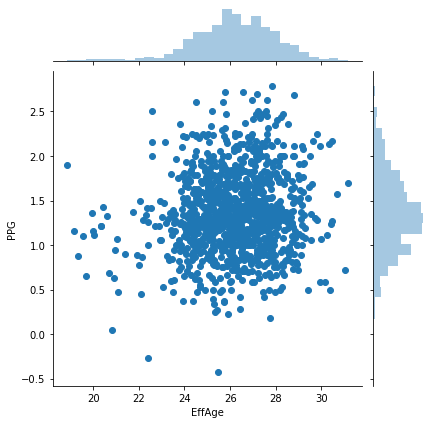

In [15]:
#def r2(x, y):
#    return stats.pearsonr(x, y)[0] ** 2
sns.jointplot(x='EffAge', y='PPG', data=for_plot, kind='scatter')

In [16]:
big5_nations = ['GER', 'ESP', 'ENG', 'FRA', 'ITA']
Big5 = for_plot[(for_plot['Country'].isin(big5_nations)) & (for_plot['Tier'] == 1)]
Big5.sort_values(by='EffAge')

,Team,League,Country,Gender,Tier,Season,URL,Pld,Pts,Max_Pts,GD,xGD,PPG,Team+Nat,EffAge
482,Leverkusen,Fußball-Bundesliga,GER,M,1,2021,https://fbref.com//en/squads/c7a9f859/Bayer-Le...,15,27,45,13,3.9,1.800000,Leverkusen (GER),23.390642
596,Spezia,Serie A,ITA,M,1,2021,https://fbref.com//en/squads/68449f6d/Spezia-S...,16,12,48,-19,-13.1,0.750000,Spezia (ITA),23.830321
446,Reims,Ligue 1,FRA,M,1,2021,https://fbref.com//en/squads/7fdd64e0/Reims-Stats,18,22,54,0,-2.6,1.222222,Reims (FRA),23.941231
486,Stuttgart,Fußball-Bundesliga,GER,M,1,2021,https://fbref.com//en/squads/598bc722/Stuttgar...,15,17,45,-3,-4.9,1.133333,Stuttgart (GER),24.147801
441,Monaco,Ligue 1,FRA,M,1,2021,https://fbref.com//en/squads/fd6114db/Monaco-S...,18,26,54,5,5.0,1.444444,Monaco (FRA),24.210481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,Burnley,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/943e8050/Burnley-...,15,11,45,-7,-7.0,0.733333,Burnley (ENG),28.744889
589,Lazio,Serie A,ITA,M,1,2021,https://fbref.com//en/squads/7213da33/Lazio-Stats,17,25,51,1,-1.9,1.470588,Lazio (ITA),28.762371
387,Granada,La Liga,ESP,M,1,2021,https://fbref.com//en/squads/a0435291/Granada-...,15,15,45,-7,-10.8,1.000000,Granada (ESP),28.937091
384,Elche,La Liga,ESP,M,1,2021,https://fbref.com//en/squads/6c8b07df/Elche-Stats,17,15,51,-8,-9.2,0.882353,Elche (ESP),29.120517


In [17]:
Big5.sort_values(by='PPG')

,Team,League,Country,Gender,Tier,Season,URL,Pld,Pts,Max_Pts,GD,xGD,PPG,Team+Nat,EffAge
478,Greuther Fürth,Fußball-Bundesliga,GER,M,1,2021,https://fbref.com//en/squads/12192a4c/Greuther...,15,4,45,-33,-13.2,0.266667,Greuther Fürth (GER),25.407190
388,Levante,La Liga,ESP,M,1,2021,https://fbref.com//en/squads/9800b6a1/Levante-...,17,8,51,-16,-2.2,0.470588,Levante (ESP),27.955638
593,Salernitana,Serie A,ITA,M,1,2021,https://fbref.com//en/squads/c5577084/Salernit...,17,8,51,-26,-12.9,0.470588,Salernitana (ITA),27.439338
582,Cagliari,Serie A,ITA,M,1,2021,https://fbref.com//en/squads/c4260e09/Cagliari...,17,10,51,-17,-12.5,0.588235,Cagliari (ITA),26.977617
585,Genoa,Serie A,ITA,M,1,2021,https://fbref.com//en/squads/658bf2de/Genoa-Stats,17,10,51,-16,-6.8,0.588235,Genoa (ITA),27.032531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,Inter,Serie A,ITA,M,1,2021,https://fbref.com//en/squads/d609edc0/Internaz...,17,40,51,28,16.2,2.352941,Inter (ITA),27.949506
273,Manchester City,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/b8fd03ef/Manchest...,16,38,48,24,26.4,2.375000,Manchester City (ENG),26.669060
473,Bayern Munich,Fußball-Bundesliga,GER,M,1,2021,https://fbref.com//en/squads/054efa67/Bayern-M...,15,37,45,31,28.2,2.466667,Bayern Munich (GER),25.797601
392,Real Madrid,La Liga,ESP,M,1,2021,https://fbref.com//en/squads/53a2f082/Real-Mad...,17,42,51,24,8.4,2.470588,Real Madrid (ESP),27.453457


In [7]:
def get_logo(team, league):
    path = f"TeamLogos/{league}-{team}.png"
    #im = plt.imread(path)
    im = Image.open(path)
    return im

def offset_image(x, y, team, league, size, ax):
    img = get_logo(team, league)
    ###########################################
    
    ###########################################
    #zoom = ((size/(2.5-0.3))*0.15)+0.1
    zoom = size
    if (team == 'RB Leipzig'): zoom = zoom + 0.08
    im = OffsetImage(img, zoom=zoom, alpha=0.85)
    #im = OffsetImage(img, zoom=0.2, alpha=0.75)
    im.image.axes = ax
    ab = AnnotationBbox(im, (x, y),  xybox=(0., 0.), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)
    ax.add_artist(ab)

In [8]:
for_plot['EffAge'] = for_plot['EffAge'].astype(float)

In [22]:
#for_plot['Country'].unique()
for_plot[for_plot['Country'] == 'ESP']['League'].unique()

array(['La Liga', 'Segunda División'], dtype=object)

In [13]:
europe = ['ENG', 'FRA', 'GER', 'ESP', 'ITA', 'POR', 'SCO', 'NED', 'BEL', 'AUT', 'RUS', 'SWE', 'DEN',
          'NOR', 'FIN', 'CRO', 'BUL', 'CZE', 'GRE', 'HUN', 'POL', 'ROU', 'SRB', 'SUI', 'TUR', 'UKR']
asia = ['AUS', 'CHN', 'IND', 'IRN', 'JPN', 'KOR', 'KSA']
for_plot[(for_plot['Tier'] == 1) & (for_plot['Country'].isin(europe))]['League'].unique()

array(['Austrian Football Bundesliga', 'Belgian First Division A',
       'First Professional Football League',
       'Croatian First Football League', 'Czech First League',
       'Superliga', 'Premier League', 'La Liga', 'Veikkausliiga',
       'Ligue 1', 'Fußball-Bundesliga', 'Super League Greece',
       'Nemzeti Bajnokság I', 'Serie A', 'Dutch Eredivisie',
       'Eliteserien', 'Ekstraklasa', 'Primeira Liga', 'Liga I',
       'Russian Premier League', 'Scottish Premiership',
       'Serbian SuperLiga', 'Swiss Super League', 'Allsvenskan',
       'Süper Lig', 'Ukrainian Premier League'], dtype=object)

In [14]:
club_spi = pd.read_csv('soccer-spi/spi_global_rankings.csv')
#club_spi = club_spi[~club_spi['league'].isin(['UEFA Champions League', 'UEFA Europa League', 'UEFA Europa Conference League'])]
club_spi = club_spi[club_spi['league'].isin(['Brasileiro Série A', 'Mexican Primera Division Torneo Clausura', 'Major League Soccer', 'Argentina Primera Division'])]
leagues_6_10 = ['Primeira Liga', 'Dutch Eredivisie', 'Russian Premier League', 'EFL Championship', 'Austrian Football Bundesliga']
leagues_11_15 = ['Belgian First Division A', 'Süper Lig', 'Swiss Super League', 'Superliga', 'Scottish Premiership']
leagues_16_20 = ['2. Fußball-Bundesliga', 'Super League Greece', 'Eliteserien', 'Serie B', 'Segunda División']
club_spi.groupby('league').mean().sort_values(by='spi', ascending=False)

,rank,prev_rank,off,def,spi
league,,,,,
Brasileiro Série A,182.650000,183.200000,1.268000,1.064500,50.341000
Mexican Primera Division Torneo Clausura,218.166667,212.944444,1.336667,1.260000,47.430556
Major League Soccer,300.074074,299.703704,1.301481,1.571111,40.045556
Argentina Primera Division,319.923077,320.230769,1.066923,1.348077,38.869615


In [148]:
for i in for_plot.index:
    if (for_plot['League'][i] == 'EFL League One'):
        for_plot['Tier'][i] = 4
    elif (for_plot['League'][i] == 'National League'):
        for_plot['Tier'][i] = 5

In [15]:
def get_fbref_offset(x):
    #return(-0.006257934 + (208223.3 - -0.006257934)/(1 + (x/1.638977e-7)**0.8415266))
    return(208223.3 - -0.006257934)/(1 + (x/1.638977e-7)**0.8415266)
get_fbref_offset(5)

0.10476346086321607

In [157]:
plots_dict = {0: {'leagues':['Premier League', 'Ligue 1', 'La Liga', 'Serie A', 'Fußball-Bundesliga'], 'title':'Effective Age in the Big 5 Leagues', 'filename': 'Big5_EffectiveMins.png'},
              1: {'leagues':leagues_6_10, 'title':'Effective Age in the 6th - 10th Best European Domestic Leagues (per 538 SPI)', 'filename':'Top_6-10_EffectiveMins.png'}, 
              2: {'leagues':leagues_11_15, 'title':'Effective Age in the 11th - 15th Best European Domestic Leagues (per 538 SPI)', 'filename':'Top_11-15_EffectiveMins.png'}, 
              3: {'leagues':leagues_16_20, 'title':'Effective Age in the 16th - 20th Best European Domestic Leagues (per 538 SPI)', 'filename':'Top_16-20_EffectiveMins.png'}, 
              4: {'leagues':['Premier League', 'Ligue 1', 'La Liga', 'Serie A', 'Fußball-Bundesliga'] + leagues_6_10, 'title':'Effective Age in the Top 10 Best European Domestic Leagues (per 538 SPI)', 'filename':'Top10_EffectiveMins.png'}, 
              5: {'leagues':['Premier League', 'Ligue 1', 'La Liga', 'Serie A', 'Fußball-Bundesliga'] + leagues_6_10 + leagues_11_15 + leagues_16_20, 'title':'Effective Age in the Top 20 Best European Domestic Leagues (per 538 SPI)', 'filename':'Top20_EffectiveMins.png'}, 
              6: {'leagues':['Major League Soccer', 'Liga MX', 'USL Championship', 'Canadian Premier League', 'USL League One'], 'title':'Effective Age in North American Leagues', 'filename':'NorthAmerica_EffectiveMins.png'}, 
              7: {'leagues':['Major League Soccer', 'Liga MX', 'Campeonato Brasileiro Série A', 'Argentine Primera División'], 'title':"Effective Age in the America's Four Biggest Domestic Leagues", 'filename':'TopAmericas_EffectiveMins.png'}, 
              8: {'leagues':for_plot[(for_plot['Country'].isin(asia)) & (for_plot['Tier'] == 1)]['League'].unique(), 'title':"Effective Age in the Asia's/Oceania's Biggest Domestic Leagues", 'filename':'TopAsian_EffectiveMins.png'}, 
              9: {'leagues':list(for_plot.groupby('League').median().sort_values(by='EffAge').index[:5]) + list(for_plot.groupby('League').median().sort_values(by='EffAge').index[-5:]), 'title':"Top 5 and Bottom 5 Domestic Leagues by Effective Age", 'filename':'Top5_Bottom5_EffectiveMins.png'}, 
              10: {'leagues':list(for_plot[for_plot['Country'] == 'ENG']['League'].unique()), 'title':"Effective Age in English Leagues", 'filename':'EnglishLeagues_EffectiveMins.png'}, 
              11: {'leagues':list(for_plot.groupby('League').median().sort_values(by='EffAge').index[:20]) + list(for_plot.groupby('League').median().sort_values(by='EffAge').index[-20:]), 'title':"Top 20 and Bottom 20 Domestic Leagues by Effective Age",'filename':'Top20_Bottom20_EffectiveMins.png'}, 
              12: {'leagues':list(for_plot[(for_plot['Tier'] == 1) & (for_plot['Country'].isin(europe))]['League'].unique()), 'title':"Effective Age in European First Tier Domestic Leagues", 'filename':'EuropeanTier1_EffectiveMins.png'}}

for k in plots_dict.keys():
#for k in [0]:
#for k in [10]:
    leagues = plots_dict[k]['leagues']
    title = plots_dict[k]['title']
    filename = plots_dict[k]['filename']
    print(filename)
    # Read in any logos that are not already read in
    for i in for_plot[for_plot['League'].isin(leagues)].index:
        #'https://d2p3bygnnzw9w3.cloudfront.net/req/202112021/tlogo/fb/b8fd03ef.png'
        url = team_urls['URL'][i]
        team = team_urls['Team'][i].replace('/','_')
        league = team_urls['League'][i]
        img_fname = league + '-' + team + ".png"
        if (img_fname in ''.join(os.listdir('TeamLogos/'))):
            continue
        else:
            print('Scraping ' + league + '-' + team + '.png')
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
        res = requests.get(url, headers=headers)
        ## The next two lines get around the issue with comments breaking the parsing
        comm = re.compile("<!--|-->")
        team_soup = BeautifulSoup(comm.sub("",res.text),'lxml')

        logo_url = team_soup.findAll('img', {'class':'teamlogo'})[0]['src']
        r = requests.get(logo_url, stream=True) #Get request on full_url
        if r.status_code == 200:                     #200 status code = OK
            with open('TeamLogos/'+img_fname, 'wb') as f: 
                r.raw.decode_content = True
                shutil.copyfileobj(r.raw, f)

        # Convert img to transparent
        img = Image.open('TeamLogos/'+img_fname)
        rgba = img.convert('RGBA')
        row_width = int(np.sqrt(len(datas)))
        # run left to right to find left edge of logo
        newData = []
        datas = rgba.getdata()
        row_ctr=0
        in_logo = False
        for item in datas:
            if ((item[0] >= 250) and (item[1] >= 250) and (item[2] >= 250) and (not in_logo)):
                newData.append((255, 255, 255, 0))
            else:
                newData.append(item)
                in_logo = True
            row_ctr+=1
            if (row_ctr >= row_width):
                row_ctr=0
                in_logo = False
        rgba.putdata(newData)
        # run right to left to find right edge of logo
        datas = rgba.getdata()
        newData = []
        row_ctr=0
        in_logo = False
        #for item in datas:
        for i in range(len(datas)-1,0,-1):
            item = datas[i]
            if ((item[0] >= 250) and (item[1] >= 250) and (item[2] >= 250) and (not in_logo)):
                newData.append((255, 255, 255, 0))
            else:
                newData.append(item)
                in_logo = True
            row_ctr+=1
            if (row_ctr >= row_width):
                row_ctr=0
                in_logo = False
        rgba.putdata(newData)
        rgba = rgba.rotate(180)
        rgba.save('TeamLogos/'+img_fname, "PNG")

    # Create the seaborn plot to get the x-y coords of all points
    leagues_w_coords = pd.DataFrame(columns=list(for_plot.columns)+['x','y'])
    ctr=0
    for league in for_plot[for_plot['League'].isin(leagues)].groupby('League').median().sort_values(by='EffAge').index:
        league_df = for_plot[for_plot['League'] == league].sort_values(by='EffAge')
        plt.figure()
        xy = sns.swarmplot(x='EffAge', size=10, data=league_df, orient='v').collections[0].get_offsets()
        plt.clf()
        league_df['x'] = xy[:,0]*5 + ctr # expand to support full logos instead of dots
        league_df['y'] = xy[:,1]
        leagues_w_coords = pd.concat([leagues_w_coords, league_df])
        ctr+=1
    n_leagues = ctr
    # Recreate the swarmplot in pyplot scatter in order to use scalable logos
    fig, ax = plt.subplots(1,1, figsize=(n_leagues*3.2,8))
    #ax.scatter(x=leagues_w_coords['x'], y=leagues_w_coords['y'], s=(leagues_w_coords['PPG']+1)*40)
    ax.scatter(x=leagues_w_coords['x'], y=leagues_w_coords['y'], s=0.001)
    ax.set_xlim((leagues_w_coords['x'].min()-0.4, leagues_w_coords['x'].max()+0.4))
    byleague = leagues_w_coords.groupby('League').median().sort_values(by='y')
    xlabels = []
    ctr=1
    for league in byleague.index:
        ax.axhline(byleague.loc[league,'EffAge'], xmin=(ctr/n_leagues)-(1/n_leagues), xmax=(ctr/n_leagues), alpha=0.5, linestyle='--')
        country = for_plot[for_plot['League'] == league]['Country'].iloc[0]
        tier = for_plot[for_plot['League'] == league]['Tier'].iloc[0]
        xlabels.append(f"{league}\n({country} {tier})")
        ctr+=1
    ax.set_xticks(byleague['x'])
    ax.set_xticklabels(byleague.index, fontsize=14)
    ax.set_xticklabels(xlabels, fontsize=14)
    #ax.set_yticks(ax.get_yticks())
    #ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
    ax.set_xlabel(' ', fontsize=30)
    max_league1 = leagues_w_coords[leagues_w_coords['x'] < 1.5]['y'].max() # We need to shift the ylim up if the min league has a high effage team
    height_ratio = (max_league1 - ax.get_ylim()[0])/(ax.get_ylim()[1] - ax.get_ylim()[0]) # so that the high team does not overlap with upper left annotations
    if (height_ratio > 0.8):
        new_ymax = max_league1 + (max_league1 - ax.get_ylim()[0])/3
        ax.set_ylim((ax.get_ylim()[0], new_ymax))
    
    ax.set_ylabel('Effective Age', fontsize=16)
    ax.set_title(title, fontsize=20)
    ax.grid(axis='y')
    y_ = .93
    x_ = 0.01
    if (title == "Effective Age in English Leagues"):
        y_ = 0.91
    if (n_leagues > 20):
        x_ = 0.001
    ax.text(x=x_, y=y_, s="-Team crests are roughly scaled to points per game", transform=ax.transAxes, horizontalalignment='left', fontsize=11)
    ax.text(x=x_, y=y_-.03, s="-Data is from 2021-22 season; collected on 12/20/21", transform=ax.transAxes, horizontalalignment='left', fontsize=11)
    ax.text(x=x_, y=y_-.06, s="-Goalkeepers excluded", transform=ax.transAxes, horizontalalignment='left', fontsize=11)
    ax.text(x=x_, y=y_-.09, s="-Effective age is the average player age,", transform=ax.transAxes, horizontalalignment='left', fontsize=11)
    ax.text(x=x_, y=y_-.115, s="   weighted by their minutes played", transform=ax.transAxes, horizontalalignment='left', fontsize=11)
    ax.text(x=x_, y=.97, s="Data source:", transform=ax.transAxes, horizontalalignment='left', fontsize=11)
    im = OffsetImage(Image.open('FBRef_Logo.png'), zoom=.12, alpha=1)
    im.image.axes = ax
    ab = AnnotationBbox(im, (get_fbref_offset(n_leagues), .98),  xybox=(0., 0.), frameon=False,
                        xycoords='axes fraction',  boxcoords="offset points", pad=0)
    ax.add_artist(ab)
    #offset_image(x=leagues_w_coords['x'][i], y=leagues_w_coords['y'][i],
    #                team=leagues_w_coords['Team'][i].replace('/','_'), league=leagues_w_coords['League'][i],
    #                 size=size, ax=ax)
    for i in leagues_w_coords.index:
        size = ((leagues_w_coords['PPG'][i]/(leagues_w_coords['PPG'].max()-leagues_w_coords['PPG'].min()))*0.15)+0.1
        offset_image(x=leagues_w_coords['x'][i], y=leagues_w_coords['y'][i],
                    team=leagues_w_coords['Team'][i].replace('/','_'), league=leagues_w_coords['League'][i],
                     size=size, ax=ax)
        
    ax.text(x=ax.get_xlim()[0]+0.02, y=byleague['EffAge'].iloc[0], s="League Median", fontsize=7, color='lightblue', alpha=0.75,
            horizontalalignment='left', verticalalignment='bottom')

    plt.tight_layout()
    plt.savefig(filename, dpi=250)
    plt.clf()

Big5_EffectiveMins.png
Top_6-10_EffectiveMins.png
Top_11-15_EffectiveMins.png
Top_16-20_EffectiveMins.png
Top10_EffectiveMins.png
Top20_EffectiveMins.png
NorthAmerica_EffectiveMins.png
TopAmericas_EffectiveMins.png
TopAsian_EffectiveMins.png
Top5_Bottom5_EffectiveMins.png
EnglishLeagues_EffectiveMins.png
Top20_Bottom20_EffectiveMins.png
EuropeanTier1_EffectiveMins.png


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 4608x576 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 921.6x576 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 1612.8x576 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 9216x576 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 5990.4x576 with 0 Axes>

In [144]:
for_plot[for_plot['League'] == 'Canadian Premier League']['EffAge'].median()

24.127708420071308

In [145]:
byleague

,xGD,PPG,EffAge,x,y
League,,,,,
Croatian First Football League,NaN,1.388889,24.681991,1.975850,24.681991
Eliteserien,NaN,1.287179,24.753627,-0.009238,24.753627
Superliga,NaN,1.343137,24.792832,2.984407,24.792832
Dutch Eredivisie,NaN,1.399306,24.820426,0.975111,24.820426
Austrian Football Bundesliga,NaN,1.342593,25.027353,4.982644,25.027353
Veikkausliiga,NaN,1.405303,25.064947,7.995579,25.064947
Belgian First Division A,NaN,1.385984,25.312685,10.013628,25.312685
Swiss Super League,NaN,1.356985,25.490580,3.983549,25.490580
Allsvenskan,NaN,1.377083,25.625595,6.965732,25.625595


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

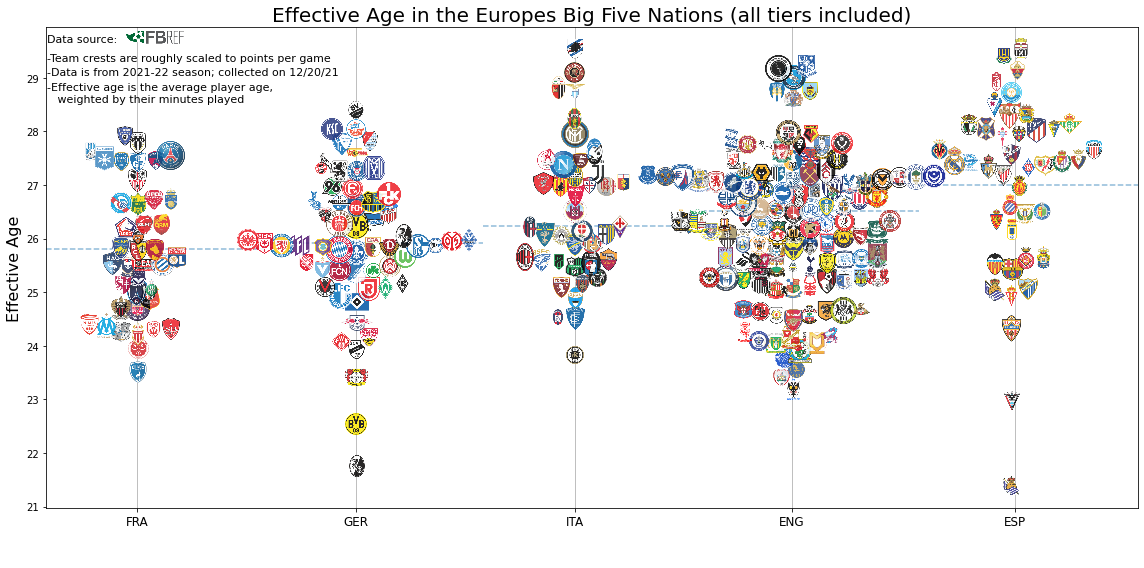

In [18]:
leagues = list(for_plot[for_plot['Country'].isin(['ENG', 'FRA', 'ESP', 'GER', 'ITA'])]['League'].unique())
title = "Effective Age in the Europes Big Five Nations (all tiers included)"
ilename = 'Big5_AllTiers_EffectiveMins.png'

# Read in any logos that are not already read in
for i in for_plot[for_plot['League'].isin(leagues)].index:
    #'https://d2p3bygnnzw9w3.cloudfront.net/req/202112021/tlogo/fb/b8fd03ef.png'
    url = team_urls['URL'][i]
    team = team_urls['Team'][i].replace('/','_')
    league = team_urls['League'][i]
    img_fname = league + '-' + team + ".png"
    if (img_fname in ''.join(os.listdir('TeamLogos/'))):
        continue
    else:
        print('Scraping ' + league + '-' + team + '.png')
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    res = requests.get(url, headers=headers)
    ## The next two lines get around the issue with comments breaking the parsing
    comm = re.compile("<!--|-->")
    team_soup = BeautifulSoup(comm.sub("",res.text),'lxml')
    
    logo_url = team_soup.findAll('img', {'class':'teamlogo'})[0]['src']
    r = requests.get(logo_url, stream=True) #Get request on full_url
    if r.status_code == 200:                     #200 status code = OK
        with open('TeamLogos/'+img_fname, 'wb') as f: 
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)
    
    # Convert img to transparent
    img = Image.open('TeamLogos/'+img_fname)
    rgba = img.convert('RGBA')
    row_width = int(np.sqrt(len(datas)))
    # run left to right to find left edge of logo
    newData = []
    datas = rgba.getdata()
    row_ctr=0
    in_logo = False
    for item in datas:
        if ((item[0] >= 250) and (item[1] >= 250) and (item[2] >= 250) and (not in_logo)):
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
            in_logo = True
        row_ctr+=1
        if (row_ctr >= row_width):
            row_ctr=0
            in_logo = False
    rgba.putdata(newData)
    # run right to left to find right edge of logo
    datas = rgba.getdata()
    newData = []
    row_ctr=0
    in_logo = False
    #for item in datas:
    for i in range(len(datas)-1,0,-1):
        item = datas[i]
        if ((item[0] >= 250) and (item[1] >= 250) and (item[2] >= 250) and (not in_logo)):
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
            in_logo = True
        row_ctr+=1
        if (row_ctr >= row_width):
            row_ctr=0
            in_logo = False
    rgba.putdata(newData)
    rgba = rgba.rotate(180)
    rgba.save('TeamLogos/'+img_fname, "PNG")

# Create the seaborn plot to get the x-y coords of all points
leagues_w_coords = pd.DataFrame(columns=list(for_plot.columns)+['x','y'])
ctr=0
for country in for_plot[for_plot['League'].isin(leagues)].groupby('Country').median().sort_values(by='EffAge').index:
    league_df = for_plot[for_plot['Country'] == country].sort_values(by='EffAge')
    plt.figure()
    xy = sns.swarmplot(x='EffAge', size=10, data=league_df, orient='v').collections[0].get_offsets()
    plt.clf()
    league_df['x'] = xy[:,0]*5 + ctr*2 # expand to support full logos instead of dots
    league_df['y'] = xy[:,1]
    leagues_w_coords = pd.concat([leagues_w_coords, league_df])
    ctr+=1
n_leagues = ctr
# Recreate the swarmplot in pyplot scatter in order to use scalable logos
fig, ax = plt.subplots(1,1, figsize=(n_leagues*3.2,8))
#ax.scatter(x=leagues_w_coords['x'], y=leagues_w_coords['y'], s=(leagues_w_coords['PPG']+1)*40)
ax.scatter(x=leagues_w_coords['x'], y=leagues_w_coords['y'], s=0.001)
ax.set_xlim((leagues_w_coords['x'].min()-0.4, leagues_w_coords['x'].max()+0.4))
byleague = leagues_w_coords.groupby('Country').mean().sort_values(by='y')
xlabels = []
ctr=1
for league in byleague.index:
    ax.axhline(byleague.loc[league,'EffAge'], xmin=(ctr/n_leagues)-(1/n_leagues), xmax=(ctr/n_leagues), alpha=0.5, linestyle='--')
    #country = for_plot[for_plot['League'] == league]['Country'].iloc[0]
    #tier = for_plot[for_plot['League'] == league]['Tier'].iloc[0]
    #xlabels.append(f"{league}\n({country} {tier})")
    xlabels.append(f"{league}")
    ctr+=1
ax.set_xticks(byleague['x'])
ax.set_xticklabels(byleague.index, fontsize=12)
ax.set_xticklabels(xlabels, fontsize=12)
#ax.set_yticks(ax.get_yticks())
#ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
ax.set_xlabel(' ', fontsize=30)
ax.set_ylabel('Effective Age', fontsize=16)
ax.set_title(title, fontsize=20)
ax.grid(axis='x')
ax.text(x=x_, y=y_, s="-Team crests are roughly scaled to points per game", transform=ax.transAxes, horizontalalignment='left', fontsize=11)
ax.text(x=x_, y=y_-.03, s="-Data is from 2021-22 season; collected on 12/20/21", transform=ax.transAxes, horizontalalignment='left', fontsize=11)
ax.text(x=x_, y=y_-.06, s="-Effective age is the average player age,", transform=ax.transAxes, horizontalalignment='left', fontsize=11)
ax.text(x=x_, y=y_-.085, s="   weighted by their minutes played", transform=ax.transAxes, horizontalalignment='left', fontsize=11)
ax.text(x=x_, y=.97, s="Data source:", transform=ax.transAxes, horizontalalignment='left', fontsize=11)
im = OffsetImage(Image.open('FBRef_Logo.png'), zoom=.12, alpha=1)
im.image.axes = ax
ab = AnnotationBbox(im, (0.1, .98),  xybox=(0., 0.), frameon=False,
                    xycoords='axes fraction',  boxcoords="offset points", pad=0)
ax.add_artist(ab)
offset_image(x=leagues_w_coords['x'][i], y=leagues_w_coords['y'][i],
                team=leagues_w_coords['Team'][i].replace('/','_'), league=leagues_w_coords['League'][i],
                 size=size, ax=ax)
for i in leagues_w_coords.index:
    size = ((leagues_w_coords['PPG'][i]/(leagues_w_coords['PPG'].max()-leagues_w_coords['PPG'].min()))*0.15)+0.1
    offset_image(x=leagues_w_coords['x'][i], y=leagues_w_coords['y'][i],
                team=leagues_w_coords['Team'][i].replace('/','_'), league=leagues_w_coords['League'][i],
                 size=size, ax=ax)

plt.tight_layout()
plt.savefig(filename, dpi=250)

In [59]:
for_plot

,Team,League,Country,Gender,Tier,Season,URL,Pld,Pts,Max_Pts,GD,xGD,PPG,Team+Nat,EffAge
0,Aldosivi,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/e5927bd8/Aldosivi...,25,33,75,-10,NaN,1.320000,Aldosivi (ARG),27.809967
1,Argentinos Jun,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/d01a653b/Argentin...,25,32,75,1,NaN,1.280000,Argentinos Jun (ARG),26.176573
2,Arsenal,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/4bee7ba3/Arsenal-...,24,20,72,-22,NaN,0.833333,Arsenal (ARG),27.181818
3,Banfield,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/06c1606c/Banfield...,24,26,72,-5,NaN,1.083333,Banfield (ARG),24.816955
4,Boca Juniors,Argentine Primera División,ARG,M,1,2021,https://fbref.com//en/squads/795ca75e/Boca-Jun...,25,41,75,16,NaN,1.640000,Boca Juniors (ARG),25.119593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,Trujillanos,Venezuelan Primera División,VEN,M,1,2021,https://fbref.com//en/squads/ee94b722/Trujilla...,24,1,72,-71,NaN,0.041667,Trujillanos (VEN),20.830028
1074,Universidad Central de Venezuela FC,Venezuelan Primera División,VEN,M,1,2021,https://fbref.com//en/squads/d254c5db/Universi...,24,31,72,2,NaN,1.291667,Universidad Central de Venezuela FC (VEN),23.281015
1075,Yaracuyanos FC,Venezuelan Primera División,VEN,M,1,2021,https://fbref.com//en/squads/bf7bd7cd/Yaracuya...,24,20,72,-16,NaN,0.833333,Yaracuyanos FC (VEN),26.319532
1076,Zamora,Venezuelan Primera División,VEN,M,1,2021,https://fbref.com//en/squads/bcdc5828/Zamora-S...,24,32,72,6,NaN,1.333333,Zamora (VEN),24.127198


In [170]:
plots_dict = {0: {'leagues':['Premier League', 'Ligue 1', 'La Liga', 'Serie A', 'Fußball-Bundesliga'], 'title':'Effective Age in the Big 5 Leagues', 'filename': 'Big5_EffectiveMins.png'}}


leagues = for_plot['League'].unique()
title = "Effective Age of All Teams"
filename = 'AllTeamsTogether.png'
print(filename)
# Read in any logos that are not already read in
for i in for_plot[for_plot['League'].isin(leagues)].index:
    #'https://d2p3bygnnzw9w3.cloudfront.net/req/202112021/tlogo/fb/b8fd03ef.png'
    url = team_urls['URL'][i]
    team = team_urls['Team'][i].replace('/','_')
    league = team_urls['League'][i]
    img_fname = league + '-' + team + ".png"
    if (img_fname in ''.join(os.listdir('TeamLogos/'))):
        continue
    else:
        print('Scraping ' + league + '-' + team + '.png')
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    res = requests.get(url, headers=headers)
    ## The next two lines get around the issue with comments breaking the parsing
    comm = re.compile("<!--|-->")
    team_soup = BeautifulSoup(comm.sub("",res.text),'lxml')

    logo_url = team_soup.findAll('img', {'class':'teamlogo'})[0]['src']
    r = requests.get(logo_url, stream=True) #Get request on full_url
    if r.status_code == 200:                     #200 status code = OK
        with open('TeamLogos/'+img_fname, 'wb') as f: 
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)

    # Convert img to transparent
    img = Image.open('TeamLogos/'+img_fname)
    rgba = img.convert('RGBA')
    # run left to right to find left edge of logo
    newData = []
    datas = rgba.getdata()
    row_width = int(np.sqrt(len(datas)))
    row_ctr=0
    in_logo = False
    for item in datas:
        if ((item[0] >= 250) and (item[1] >= 250) and (item[2] >= 250) and (not in_logo)):
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
            in_logo = True
        row_ctr+=1
        if (row_ctr >= row_width):
            row_ctr=0
            in_logo = False
    rgba.putdata(newData)
    # run right to left to find right edge of logo
    datas = rgba.getdata()
    newData = []
    row_ctr=0
    in_logo = False
    #for item in datas:
    for i in range(len(datas)-1,0,-1):
        item = datas[i]
        if ((item[0] >= 250) and (item[1] >= 250) and (item[2] >= 250) and (not in_logo)):
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
            in_logo = True
        row_ctr+=1
        if (row_ctr >= row_width):
            row_ctr=0
            in_logo = False
    rgba.putdata(newData)
    rgba = rgba.rotate(180)
    rgba.save('TeamLogos/'+img_fname, "PNG")

# Create the seaborn plot to get the x-y coords of all points
leagues_w_coords = pd.DataFrame(columns=list(for_plot.columns)+['x','y'])
ctr=0
#for league in for_plot[for_plot['League'].isin(leagues)].groupby('League').median().sort_values(by='EffAge').index:
#league_df = for_plot[for_plot['League'] == league].sort_values(by='EffAge')
league_df = for_plot.sort_values(by='EffAge')
plt.figure()
xy = sns.swarmplot(x='EffAge', size=3.5, data=league_df, orient='v').collections[0].get_offsets()
plt.clf()
#league_df['x'] = xy[:,0]*5 + ctr # expand to support full logos instead of dots
league_df['x'] = xy[:,0]
league_df['y'] = xy[:,1]
leagues_w_coords = pd.concat([leagues_w_coords, league_df])
ctr+=1
n_leagues = ctr
# Recreate the swarmplot in pyplot scatter in order to use scalable logos
fig, ax = plt.subplots(1,1, figsize=(12,8))
#ax.scatter(x=leagues_w_coords['x'], y=leagues_w_coords['y'], s=(leagues_w_coords['PPG']+1)*40)
ax.scatter(x=leagues_w_coords['x'], y=leagues_w_coords['y'], s=0.001)
ax.set_xlim((leagues_w_coords['x'].min()-0.4, leagues_w_coords['x'].max()+0.4))
byleague = leagues_w_coords.groupby('League').mean().sort_values(by='y')
xlabels = []
ctr=1
for league in byleague.index:
    #ax.axhline(byleague.loc[league,'EffAge'], xmin=(ctr/n_leagues)-(1/n_leagues), xmax=(ctr/n_leagues), alpha=0.5, linestyle='--')
    country = for_plot[for_plot['League'] == league]['Country'].iloc[0]
    tier = for_plot[for_plot['League'] == league]['Tier'].iloc[0]
    xlabels.append(f"{league}\n({country} {tier})")
    ctr+=1
ax.axhline(for_plot['EffAge'].median(), xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], alpha=0.5, linestyle='--')
ax.set_xticks([0])
ax.set_xticklabels([''])
#ax.set_xticklabels(xlabels, fontsize=14)
#ax.set_yticks(ax.get_yticks())
#ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
ax.set_xlabel(' ', fontsize=30)
#max_league1 = leagues_w_coords[leagues_w_coords['x'] < 1.5]['y'].max() # We need to shift the ylim up if the min league has a high effage team
#height_ratio = (max_league1 - ax.get_ylim()[0])/(ax.get_ylim()[1] - ax.get_ylim()[0]) # so that the high team does not overlap with upper left annotations
#if (height_ratio > 0.8):
#    new_ymax = max_league1 + (max_league1 - ax.get_ylim()[0])/3
#    ax.set_ylim((ax.get_ylim()[0], new_ymax))

ax.set_ylabel('Effective Age', fontsize=16)
ax.set_title(title, fontsize=20)
ax.grid(axis='y')
y_ = .93
x_ = 0.01
if (title == "Effective Age in English Leagues"):
    y_ = 0.91
if (n_leagues > 20):
    x_ = 0.001
ax.text(x=x_, y=y_, s="-Team crests are roughly scaled to points per game", transform=ax.transAxes, horizontalalignment='left', fontsize=11)
ax.text(x=x_, y=y_-.03, s="-Data is from 2021-22 season; collected on 12/20/21", transform=ax.transAxes, horizontalalignment='left', fontsize=11)
ax.text(x=x_, y=y_-.06, s="-Goalkeepers excluded", transform=ax.transAxes, horizontalalignment='left', fontsize=11)
ax.text(x=x_, y=y_-.09, s="-Effective age is the average player age,", transform=ax.transAxes, horizontalalignment='left', fontsize=11)
ax.text(x=x_, y=y_-.115, s="   weighted by their minutes played", transform=ax.transAxes, horizontalalignment='left', fontsize=11)
ax.text(x=x_, y=.97, s="Data source:", transform=ax.transAxes, horizontalalignment='left', fontsize=11)
im = OffsetImage(Image.open('FBRef_Logo.png'), zoom=.12, alpha=1)
im.image.axes = ax
ab = AnnotationBbox(im, (.15, .98),  xybox=(0., 0.), frameon=False,
                    xycoords='axes fraction',  boxcoords="offset points", pad=0)
ax.add_artist(ab)
#offset_image(x=leagues_w_coords['x'][i], y=leagues_w_coords['y'][i],
#                team=leagues_w_coords['Team'][i].replace('/','_'), league=leagues_w_coords['League'][i],
#                 size=size, ax=ax)
for i in leagues_w_coords.index:
    #size = ((leagues_w_coords['PPG'][i]/(leagues_w_coords['PPG'].max()-leagues_w_coords['PPG'].min()))*0.15)+0.1
    #size = ((.01/(leagues_w_coords['PPG'].max()-leagues_w_coords['PPG'].min()))*0.15)+0.1
    size = 0.08
    offset_image(x=leagues_w_coords['x'][i], y=leagues_w_coords['y'][i],
                team=leagues_w_coords['Team'][i].replace('/','_'), league=leagues_w_coords['League'][i],
                 size=size, ax=ax)
ax.text(x=ax.get_xlim()[0]+0.02, y=for_plot['EffAge'].median(), s="Median", fontsize=7, color='lightblue', alpha=0.75,
            horizontalalignment='left', verticalalignment='bottom')

plt.tight_layout()
fig.subplots_adjust(top=.95, bottom=0.05)
plt.savefig(filename, dpi=450)
plt.clf()

AllTeamsTogether.png


<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

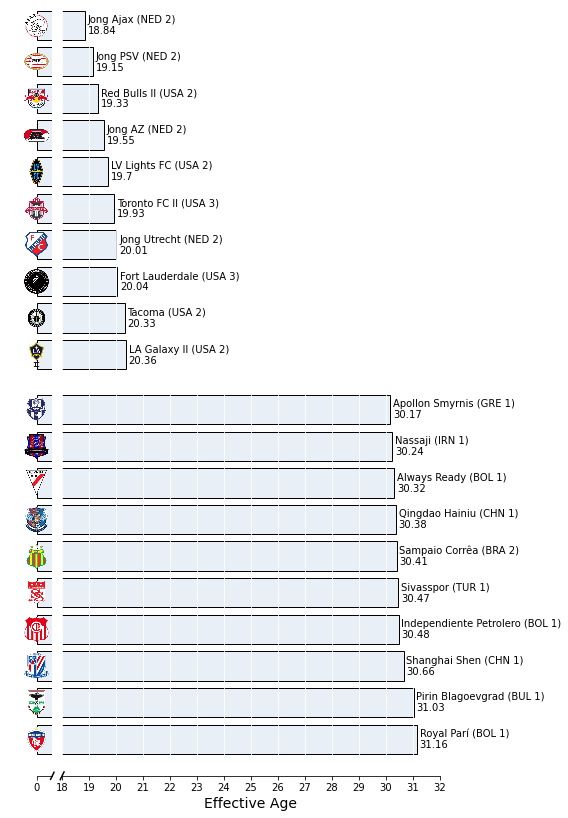

In [171]:
bars = list(for_plot.sort_values(by='EffAge').reset_index(drop=True)['EffAge'][:10]) + list(for_plot.sort_values(by='EffAge').reset_index(drop=True)['EffAge'][-10:])
#y_coord = [10.5, 9.5, 8.5, 7.5, 6.5, 5, 4, 3, 2, 1]
y_coord = [20.5, 19.5, 18.5, 17.5, 16.5, 15.5, 14.5, 13.5, 12.5, 11.5, 10,9,8,7,6,5,4,3,2,1]


labels = list(for_plot.sort_values(by='EffAge').reset_index(drop=True)['Team'][:10]) + list(for_plot.sort_values(by='EffAge').reset_index(drop=True)['Team'][-10:])
leagues = list(for_plot.sort_values(by='EffAge').reset_index(drop=True)['League'][:10]) + list(for_plot.sort_values(by='EffAge').reset_index(drop=True)['League'][-10:])
idxs = list(for_plot.sort_values(by='EffAge').index[:10]) + list(for_plot.sort_values(by='EffAge').index[-10:])

def offset_image2(x, y, team, league, size, ax):
    img = get_logo(team, league)
    ###########################################
    
    ###########################################
    #zoom = ((size/(2.5-0.3))*0.15)+0.1
    zoom = size
    if (team == 'RB Leipzig'): zoom = zoom + 0.08
    im = OffsetImage(img, zoom=zoom, alpha=1)
    #im = OffsetImage(img, zoom=0.2, alpha=0.75)
    im.image.axes = ax
    ab = AnnotationBbox(im, (x, y),  xybox=(0., 0.), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)
    ax.add_artist(ab)


background_color = 'white' # light tan
#text_color='#060322' # dark dark blue
text_color = 'black'
#edge_color='#BAC2CC' # light blue grey
edge_color = 'black'
#color_dict = {'A':'#FFC300', 'B':'#FF5733', 'C':'#C70039', np.nan:background_color}
fill_color = '#e9eff6'

fig, ax = plt.subplots(1,2, figsize=(8,12), sharey=True,
                       gridspec_kw={'width_ratios':[1,24], 'wspace':0.05})

#plt.rcParams['axes.facecolor'] = background_color

ax[0].spines['left'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].tick_params(axis='y', colors=background_color)
ax[1].tick_params(axis='y', colors=background_color)
#ax[0].set_yticklabels(labels=teams, color=background_color, fontsize=16)
#ax[1].set_yticklabels(labels=teams, color=background_color, fontsize=16)
ax[0].set_xticks([0])
ax[0].set_xticklabels(labels=[0], color=text_color)
ax[1].set_xticks([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])
ax[1].set_xticklabels(labels=[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32], color=text_color)
ax[1].set_xlabel("Effective Age", color=text_color, fontsize=14)
ax[0].set_xlim(0,1)
ax[1].set_xlim(18,32)
ax[0].set_ylim((0,21))
ax[1].set_ylim((0,21))

for i in range(20):
    y = y_coord[i]
    #offset_image(coord=y, name=share_sorted['Team'][i], ax=ax[0])
    offset_image2(x=0, y=y,
                team=labels[i].replace('/','_'), league=leagues[i],
                 size=.2, ax=ax[0])
    
    width = bars[i]
    col = fill_color
    ax[0].barh(y=[y], width=[width], color=col, edgecolor='black')
    ax[1].barh(y=[y], width=[width], color=col, edgecolor='black')
    
    x = width + 0.1
    s = f"{labels[i]} ({for_plot['Country'][idxs[i]]} {for_plot['Tier'][idxs[i]]})"
    ax[1].text(x=x, y=y+0.15, s=s, va='center', ha='left', color=text_color)
    
    x = width + 0.1
    s = f"{round(width,2)}"
    ax[1].text(x=x, y=y-0.15, s=s, va='center', ha='left', color=text_color)
    
    
    
ax[1].grid(axis='x', color=background_color)
    


# add diagonal lines for axis break
d=0.005*22
kwargs = dict(transform=ax[0].transAxes, color='black', clip_on=False)
ax[0].plot((1-d,1+d), (-d/24, +d/24), **kwargs)
d=0.005
kwargs.update(transform=ax[1].transAxes)
ax[1].plot((-d,+d), (-d,+d), **kwargs)

#fig.suptitle("Oldest and Youngest Teams by Effective Age", y=.97, fontsize=22)

fig.patch.set_facecolor(background_color)
plt.tight_layout()
fig.subplots_adjust(top=.95, bottom=.06, left=0.05, right=.75)

plt.savefig('AllTeamsBar.png', facecolor=background_color, dpi=300)

In [172]:
"""Merge two images into one, displayed side by side
:param file1: path to first image file
:param file2: path to second image file
:return: the merged Image object
"""
file1 = 'AllTeamsTogether.png'
file2 = 'AllTeamsBar.png'
image1 = Image.open(file1)
image2 = Image.open(file2)

(width1, height1) = image1.size
(width2, height2) = image2.size

result_width = width1 + width2
result_height = max(height1, height2)

result = Image.new('RGB', (result_width, result_height))
result.paste(im=image1, box=(0, 0))
result.paste(im=image2, box=(width1, 0))
result.save('AllTeams_Swarm_and_Bar.png')

### Looking for a relationship between effective age and PPG/GD/xGD

#### Possibly make an adjustment for effective age relative to league average

In [118]:
big5_nations = ['ENG', 'GER', 'FRA', 'ESP', 'ITA']
big5_teams = for_plot[(for_plot['Country'].isin(big5_nations)) & (for_plot['Tier'] == 1)]
big5_teams

,Team,League,Country,Gender,Tier,Season,URL,Pld,Pts,Max_Pts,GD,xGD,PPG,Team+Nat,EffAge
262,Arsenal,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/18bb7c10/Arsenal-...,16,26,48,-1,-4.1,1.625000,Arsenal (ENG),24.479125
263,Aston Villa,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/8602292d/Aston-Vi...,16,19,48,-4,-6.8,1.187500,Aston Villa (ENG),25.631300
264,Brentford,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/cd051869/Brentfor...,16,20,48,-1,1.4,1.250000,Brentford (ENG),25.274682
265,Brighton,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/d07537b9/Brighton...,15,20,45,-2,-1.4,1.333333,Brighton (ENG),26.844097
266,Burnley,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/943e8050/Burnley-...,15,11,45,-7,-7.0,0.733333,Burnley (ENG),28.744889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,Sassuolo,Serie A,ITA,M,1,2021,https://fbref.com//en/squads/e2befd26/Sassuolo...,17,23,51,2,-1.6,1.352941,Sassuolo (ITA),25.464901
596,Spezia,Serie A,ITA,M,1,2021,https://fbref.com//en/squads/68449f6d/Spezia-S...,16,12,48,-19,-13.1,0.750000,Spezia (ITA),23.830321
597,Torino,Serie A,ITA,M,1,2021,https://fbref.com//en/squads/105360fe/Torino-S...,17,22,51,4,4.8,1.294118,Torino (ITA),25.077448
598,Udinese,Serie A,ITA,M,1,2021,https://fbref.com//en/squads/04eea015/Udinese-...,17,17,51,-6,0.0,1.000000,Udinese (ITA),26.057937


In [119]:
big5_teams['League'].unique()

array(['Premier League', 'La Liga', 'Ligue 1', 'Fußball-Bundesliga',
       'Serie A'], dtype=object)

In [120]:
# Let's get the last 5 season of big five data
big5_urls = {'Premier League': {'Country':'ENG', 'Tier':1, 'season':{2020: 'https://fbref.com/en/comps/9/10728/2020-2021-Premier-League-Stats', 2019: 'https://fbref.com/en/comps/9/3232/2019-2020-Premier-League-Stats', 2018: 'https://fbref.com/en/comps/9/1889/2018-2019-Premier-League-Stats', 2017: 'https://fbref.com/en/comps/9/1631/2017-2018-Premier-League-Stats', 2016: 'https://fbref.com/en/comps/9/1526/2016-2017-Premier-League-Stats'}},
            'Fußball-Bundesliga': {'Country':'GER', 'Tier':1, 'season':{2020:'https://fbref.com/en/comps/20/10737/2020-2021-Bundesliga-Stats', 2019:'https://fbref.com/en/comps/20/3248/2019-2020-Bundesliga-Stats', 2018:'https://fbref.com/en/comps/20/2109/2018-2019-Bundesliga-Stats', 2017:'https://fbref.com/en/comps/20/1634/2017-2018-Bundesliga-Stats', 2016:'https://fbref.com/en/comps/20/1529/2016-2017-Bundesliga-Stats'}},
            'Ligue 1': {'Country':'FRA', 'Tier':1, 'season':{2020:'https://fbref.com/en/comps/13/10732/2020-2021-Ligue-1-Stats', 2019:'https://fbref.com/en/comps/13/3243/2019-2020-Ligue-1-Stats', 2018:'https://fbref.com/en/comps/13/2104/2018-2019-Ligue-1-Stats', 2017:'https://fbref.com/en/comps/13/1632/2017-2018-Ligue-1-Stats', 2016:'https://fbref.com/en/comps/13/1527/2016-2017-Ligue-1-Stats'}},
            'La Liga': {'Country':'ESP', 'Tier':1, 'season':{2020:'https://fbref.com/en/comps/12/10731/2020-2021-La-Liga-Stats', 2019:'https://fbref.com/en/comps/12/3239/2019-2020-La-Liga-Stats', 2018:'https://fbref.com/en/comps/12/1886/2018-2019-La-Liga-Stats', 2017:'https://fbref.com/en/comps/12/1652/2017-2018-La-Liga-Stats', 2016:'https://fbref.com/en/comps/12/1547/2016-2017-La-Liga-Stats'}},
            'Serie A': {'Country':'ITA', 'Tier':1, 'season':{2020:'https://fbref.com/en/comps/11/10730/2020-2021-Serie-A-Stats', 2019:'https://fbref.com/en/comps/11/3260/2019-2020-Serie-A-Stats', 2018:'https://fbref.com/en/comps/11/1896/2018-2019-Serie-A-Stats', 2017:'https://fbref.com/en/comps/11/1640/2017-2018-Serie-A-Stats', 2016:'https://fbref.com/en/comps/11/1535/2016-2017-Serie-A-Stats'}}}

In [121]:
big5_team_urls = team_urls[(team_urls['Country'].isin(big5_nations)) & (team_urls['Tier'] == 1)].reset_index(drop=True)
big5_team_urls

,Team,League,Country,Gender,Tier,Season,URL,Pld,Pts,Max_Pts,GD,xGD,PPG,Team+Nat
0,Arsenal,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/18bb7c10/Arsenal-...,16,26,48,-1,-4.1,1.625000,Arsenal (ENG)
1,Aston Villa,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/8602292d/Aston-Vi...,16,19,48,-4,-6.8,1.187500,Aston Villa (ENG)
2,Brentford,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/cd051869/Brentfor...,16,20,48,-1,1.4,1.250000,Brentford (ENG)
3,Brighton,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/d07537b9/Brighton...,15,20,45,-2,-1.4,1.333333,Brighton (ENG)
4,Burnley,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/943e8050/Burnley-...,15,11,45,-7,-7.0,0.733333,Burnley (ENG)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,Sassuolo,Serie A,ITA,M,1,2021,https://fbref.com//en/squads/e2befd26/Sassuolo...,17,23,51,2,-1.6,1.352941,Sassuolo (ITA)
94,Spezia,Serie A,ITA,M,1,2021,https://fbref.com//en/squads/68449f6d/Spezia-S...,16,12,48,-19,-13.1,0.750000,Spezia (ITA)
95,Torino,Serie A,ITA,M,1,2021,https://fbref.com//en/squads/105360fe/Torino-S...,17,22,51,4,4.8,1.294118,Torino (ITA)
96,Udinese,Serie A,ITA,M,1,2021,https://fbref.com//en/squads/04eea015/Udinese-...,17,17,51,-6,0.0,1.000000,Udinese (ITA)


In [122]:
big5_players = All_Players[(All_Players['Country'].isin(big5_nations)) & (All_Players['Tier'] == 1)].reset_index(drop=True)
big5_players

,Team,League,Country,Gender,Tier,Season,URL,Pld,Pts,Max_Pts,GD,xGD,player,nationality,position,age,age_dec,minutes,goals,assists,xg,xa
0,Arsenal,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/18bb7c10/Arsenal-...,18,32,54,4,-0.1,Ben White,ENG,DF,24.0,24.202740,1440,0,0,0.2,0.2
1,Arsenal,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/18bb7c10/Arsenal-...,18,32,54,4,-0.1,Bukayo Saka,ENG,"MF,FW",20.0,20.293151,1321,3,4,4.1,4.1
2,Arsenal,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/18bb7c10/Arsenal-...,18,32,54,4,-0.1,Aaron Ramsdale,ENG,GK,23.0,23.605479,1350,0,0,0.0,0.0
3,Arsenal,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/18bb7c10/Arsenal-...,18,32,54,4,-0.1,Gabriel Dos Santos,BRA,DF,24.0,24.005479,1328,2,0,0.9,0.9
4,Arsenal,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/18bb7c10/Arsenal-...,18,32,54,4,-0.1,Takehiro Tomiyasu,JPN,DF,23.0,23.126027,1294,0,1,0.3,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,Venezia,Serie A,ITA,M,1,2021,https://fbref.com//en/squads/af5d5982/Venezia-...,18,17,54,-14,-12.3,Nicolas Galazzi,ITA,DF,21.0,21.008219,16,0,0,0.0,0.0
2972,Venezia,Serie A,ITA,M,1,2021,https://fbref.com//en/squads/af5d5982/Venezia-...,18,17,54,-14,-12.3,Bjarki Bjarkason,ISL,FW,21.0,21.613699,0,0,0,0.0,0.0
2973,Venezia,Serie A,ITA,M,1,2021,https://fbref.com//en/squads/af5d5982/Venezia-...,18,17,54,-14,-12.3,Bruno,BRA,GK,23.0,23.558904,0,0,0,0.0,0.0
2974,Venezia,Serie A,ITA,M,1,2021,https://fbref.com//en/squads/af5d5982/Venezia-...,18,17,54,-14,-12.3,Óttar Magnús Karlsson,ISL,FW,24.0,24.830137,0,0,0,0.0,0.0


In [123]:
teams_to_append = pd.DataFrame(columns=big5_team_urls.columns, index=range(999))

ctr=0
for league in big5_urls.keys():
    for year in big5_urls[league]['season'].keys():
        url = big5_urls[league]['season'][year]
        print(league, '-', year, '-', big5_urls[league]['season'][year])
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
        res = requests.get(url, headers=headers)
        ## The next two lines get around the issue with comments breaking the parsing
        comm = re.compile("<!--|-->")
        league_soup = BeautifulSoup(comm.sub("",res.text),'lxml')
        tables = league_soup.findAll('table')

        for t in range(len(tables)):
            if (len(tables[t].findAll('tr')) == 0):
                continue
            elif (len(tables[t].findAll('tr')[0].findAll('th', {'data-stat':'wins'})) > 0):
                rows = league_soup.findAll('table')[t].findAll('tr')
                for r in range(1,len(rows)):
                    row = rows[r]
                    if ('blank_table' in str(row)): continue
                    teams_to_append['Team'][ctr] = row.findAll('td')[0].text[1:]
                    teams_to_append['Pld'][ctr] = int(row.findAll('td', {'data-stat':'games'})[0].text)
                    teams_to_append['Pts'][ctr] = int(row.findAll('td', {'data-stat':'points'})[0].text)
                    teams_to_append['Max_Pts'][ctr] = teams_to_append['Pld'][ctr]*3
                    teams_to_append['GD'][ctr] = int(row.findAll('td', {'data-stat':'goal_diff'})[0].text)
                    teams_to_append['Country'][ctr] = big5_urls[league]['Country']
                    teams_to_append['League'][ctr] = league
                    teams_to_append['Gender'][ctr] = 'M'
                    teams_to_append['Tier'][ctr] = big5_urls[league]['Tier']
                    teams_to_append['Season'][ctr] = year
                    teams_to_append['URL'][ctr] = 'https://fbref.com/' + row.findAll('a', href=True)[0]['href']
                    xgd = row.findAll('td', {'data-stat':'xg_diff'})
                    if (len(xgd) == 1): teams_to_append['xGD'][ctr] = float(xgd[0].text)
                    else: teams_to_append['xGD'][ctr] = np.nan
                    ctr+=1
        time.sleep(2)
teams_to_append = teams_to_append.dropna(how='all').reset_index(drop=True)
teams_to_append['PPG'] = teams_to_append['Pts'] / teams_to_append['Pld']
teams_to_append

Premier League - 2020 - https://fbref.com/en/comps/9/10728/2020-2021-Premier-League-Stats
Premier League - 2019 - https://fbref.com/en/comps/9/3232/2019-2020-Premier-League-Stats
Premier League - 2018 - https://fbref.com/en/comps/9/1889/2018-2019-Premier-League-Stats
Premier League - 2017 - https://fbref.com/en/comps/9/1631/2017-2018-Premier-League-Stats
Premier League - 2016 - https://fbref.com/en/comps/9/1526/2016-2017-Premier-League-Stats
Fußball-Bundesliga - 2020 - https://fbref.com/en/comps/20/10737/2020-2021-Bundesliga-Stats
Fußball-Bundesliga - 2019 - https://fbref.com/en/comps/20/3248/2019-2020-Bundesliga-Stats
Fußball-Bundesliga - 2018 - https://fbref.com/en/comps/20/2109/2018-2019-Bundesliga-Stats
Fußball-Bundesliga - 2017 - https://fbref.com/en/comps/20/1634/2017-2018-Bundesliga-Stats
Fußball-Bundesliga - 2016 - https://fbref.com/en/comps/20/1529/2016-2017-Bundesliga-Stats
Ligue 1 - 2020 - https://fbref.com/en/comps/13/10732/2020-2021-Ligue-1-Stats
Ligue 1 - 2019 - https://f

,Team,League,Country,Gender,Tier,Season,URL,Pld,Pts,Max_Pts,GD,xGD,PPG,Team+Nat
0,Manchester City,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/b8fd03ef/2020-202...,38,86,114,51,42.0,2.263158,NaN
1,Manchester Utd,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/19538871/2020-202...,38,74,114,29,18.0,1.947368,NaN
2,Liverpool,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/822bd0ba/2020-202...,38,69,114,26,27.3,1.815789,NaN
3,Chelsea,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/cff3d9bb/2020-202...,38,67,114,22,31.2,1.763158,NaN
4,Leicester City,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/a2d435b3/2020-202...,38,66,114,18,8.3,1.736842,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,Genoa,Serie A,ITA,M,1,2016,https://fbref.com//en/squads/658bf2de/2016-201...,38,36,114,-26,NaN,0.947368,NaN
486,Crotone,Serie A,ITA,M,1,2016,https://fbref.com//en/squads/3074d7b1/2016-201...,38,34,114,-24,NaN,0.894737,NaN
487,Empoli,Serie A,ITA,M,1,2016,https://fbref.com//en/squads/a3d88bd8/2016-201...,38,32,114,-32,NaN,0.842105,NaN
488,Palermo,Serie A,ITA,M,1,2016,https://fbref.com//en/squads/ee058a17/2016-201...,38,26,114,-44,NaN,0.684211,NaN


In [124]:
teams_to_append[pd.isna(teams_to_append['xGD'])]['Season'].unique() # no xG for 2016 - leave it out for now

array([2016], dtype=object)

In [125]:
xg_leagues = list(team_urls[~pd.isna(team_urls['xGD'])]['League'].unique())

players_tmp = pd.DataFrame(columns=list(teams_to_append.columns)+['player', 'nationality', 'position', 'age', 'age_dec', 'minutes', 'goals', 'assists'])

for t in teams_to_append.index:
#for t in [262]:
    print(teams_to_append['Team'][t], '-', teams_to_append['League'][t], '-', teams_to_append['Country'][t])
    url = teams_to_append['URL'][t]
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    res = requests.get(url, headers=headers)
    ## The next two lines get around the issue with comments breaking the parsing
    comm = re.compile("<!--|-->")
    team_soup = BeautifulSoup(comm.sub("",res.text),'lxml')
    rows = team_soup.findAll('table')[0].findAll('tr')
    if ('Venue' in rows[0].text): continue
    
    team_df = pd.DataFrame(columns=list(teams_to_append.columns)+['player', 'nationality', 'position', 'age', 'age_dec', 'minutes', 'goals', 'assists', 'xg', 'xa'], index=range(99))
    for r in range(2,len(rows)-1):
        name = rows[r].findAll('th')[0].text
        if (name == 'Squad Total'): continue
        team_df['player'][r] = name
        data_stats = ['nationality', 'position', 'minutes', 'goals', 'assists']
        nation_split = rows[r].findAll('td', {'data-stat':'nationality'})[0].text.split(' ')
        if (len(nation_split) == 2):
            team_df['nationality'][r] = nation_split[1]
        elif (nation_split[0] == ''):
            team_df['nationality'][r] = np.nan
        else:
            team_df['nationality'][r] = nation_split[0]
            
        team_df['position'][r] = rows[r].findAll('td', {'data-stat':'position'})[0].text
        
        try:
            team_df['age'][r] = int(rows[r].findAll('td', {'data-stat':'age'})[0].text.split('-')[0])
            if (len(rows[r].findAll('td', {'data-stat':'age'})[0].text.split('-')) == 2):
                team_df['age_dec'][r] = float(rows[r].findAll('td', {'data-stat':'age'})[0].text.split('-')[0]) + (float(rows[r].findAll('td', {'data-stat':'age'})[0].text.split('-')[1]) / 365)
            else:
                team_df['age_dec'][r] = team_df['age'][r]
        except ValueError:
            team_df['age'][r] = np.nan
            team_df['age_dec'][r] = np.nan
        
        try:
            team_df['minutes'][r] = int(rows[r].findAll('td', {'data-stat':'minutes'})[0].text.replace(',',''))
        except ValueError:
            team_df['minutes'][r] = 0
            
        try:
            team_df['goals'][r] = int(rows[r].findAll('td', {'data-stat':'goals'})[0].text)
        except ValueError:
            team_df['goals'][r] = 0
            
        try:
            team_df['assists'][r] = int(rows[r].findAll('td', {'data-stat':'assists'})[0].text)
        except ValueError:
            team_df['assists'][r] = 0
            
        if ((teams_to_append['League'][t] in xg_leagues) and (teams_to_append['Season'][t] > 2016)):
            try:
                team_df['xg'][r] = float(rows[r].findAll('td', {'data-stat':'xg'})[0].text)
            except ValueError:
                team_df['xg'][r] = 0
                
            try:
                team_df['xa'][r] = float(rows[r].findAll('td', {'data-stat':'xg'})[0].text)
            except ValueError:
                team_df['xa'][r] = 0
            
    team_df = team_df.dropna(how='all').reset_index(drop=True)
    team_df[teams_to_append.columns] = teams_to_append.loc[t]
    players_tmp = pd.concat([players_tmp,team_df]).reset_index(drop=True)
    time.sleep(1)
players_tmp

Manchester City - Premier League - ENG
Manchester Utd - Premier League - ENG
Liverpool - Premier League - ENG
Chelsea - Premier League - ENG
Leicester City - Premier League - ENG
West Ham - Premier League - ENG
Tottenham - Premier League - ENG
Arsenal - Premier League - ENG
Leeds United - Premier League - ENG
Everton - Premier League - ENG
Aston Villa - Premier League - ENG
Newcastle Utd - Premier League - ENG
Wolves - Premier League - ENG
Crystal Palace - Premier League - ENG
Southampton - Premier League - ENG
Brighton - Premier League - ENG
Burnley - Premier League - ENG
Fulham - Premier League - ENG
West Brom - Premier League - ENG
Sheffield Utd - Premier League - ENG
Liverpool - Premier League - ENG
Manchester City - Premier League - ENG
Manchester Utd - Premier League - ENG
Chelsea - Premier League - ENG
Leicester City - Premier League - ENG
Tottenham - Premier League - ENG
Wolves - Premier League - ENG
Arsenal - Premier League - ENG
Sheffield Utd - Premier League - ENG
Burnley - 

Caen - Ligue 1 - FRA
Guingamp - Ligue 1 - FRA
Paris S-G - Ligue 1 - FRA
Monaco - Ligue 1 - FRA
Lyon - Ligue 1 - FRA
Marseille - Ligue 1 - FRA
Rennes - Ligue 1 - FRA
Bordeaux - Ligue 1 - FRA
Saint-Étienne - Ligue 1 - FRA
Nice - Ligue 1 - FRA
Nantes - Ligue 1 - FRA
Montpellier - Ligue 1 - FRA
Dijon - Ligue 1 - FRA
Guingamp - Ligue 1 - FRA
Amiens - Ligue 1 - FRA
Angers - Ligue 1 - FRA
Strasbourg - Ligue 1 - FRA
Caen - Ligue 1 - FRA
Lille - Ligue 1 - FRA
Toulouse - Ligue 1 - FRA
Troyes - Ligue 1 - FRA
Metz - Ligue 1 - FRA
Monaco - Ligue 1 - FRA
Paris S-G - Ligue 1 - FRA
Nice - Ligue 1 - FRA
Lyon - Ligue 1 - FRA
Marseille - Ligue 1 - FRA
Bordeaux - Ligue 1 - FRA
Nantes - Ligue 1 - FRA
Saint-Étienne - Ligue 1 - FRA
Rennes - Ligue 1 - FRA
Guingamp - Ligue 1 - FRA
Lille - Ligue 1 - FRA
Angers - Ligue 1 - FRA
Toulouse - Ligue 1 - FRA
Metz - Ligue 1 - FRA
Montpellier - Ligue 1 - FRA
Dijon - Ligue 1 - FRA
Caen - Ligue 1 - FRA
Lorient - Ligue 1 - FRA
Nancy - Ligue 1 - FRA
Bastia - Ligue 1 - FRA
At

,Team,League,Country,Gender,Tier,Season,URL,Pld,Pts,Max_Pts,GD,xGD,PPG,Team+Nat,player,nationality,position,age,age_dec,minutes,goals,assists,xg,xa
0,Manchester City,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/b8fd03ef/2020-202...,38,86,114,51,42.0,2.263158,NaN,Ederson,BRA,GK,26,26,3240,0,1,0.0,0.0
1,Manchester City,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/b8fd03ef/2020-202...,38,86,114,51,42.0,2.263158,NaN,Rúben Dias,POR,DF,23,23,2843,1,0,2.4,2.4
2,Manchester City,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/b8fd03ef/2020-202...,38,86,114,51,42.0,2.263158,NaN,Rodri,ESP,MF,24,24,2748,2,2,2.5,2.5
3,Manchester City,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/b8fd03ef/2020-202...,38,86,114,51,42.0,2.263158,NaN,Raheem Sterling,ENG,FW,25,25,2536,10,7,12.2,12.2
4,Manchester City,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/b8fd03ef/2020-202...,38,86,114,51,42.0,2.263158,NaN,João Cancelo,POR,DF,26,26,2299,2,3,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16194,Pescara,Serie A,ITA,M,1,2016,https://fbref.com//en/squads/b985784c/2016-201...,38,18,114,-44,NaN,0.473684,NaN,Simone Mancini,ITA,FW,17,17,0,0,0,NaN,NaN
16195,Pescara,Serie A,ITA,M,1,2016,https://fbref.com//en/squads/b985784c/2016-201...,38,18,114,-44,NaN,0.473684,NaN,Francesco Mele,ITA,MF,18,18,0,0,0,NaN,NaN
16196,Pescara,Serie A,ITA,M,1,2016,https://fbref.com//en/squads/b985784c/2016-201...,38,18,114,-44,NaN,0.473684,NaN,Mirko Pigliacelli,ITA,GK,23,23,0,0,0,NaN,NaN
16197,Pescara,Serie A,ITA,M,1,2016,https://fbref.com//en/squads/b985784c/2016-201...,38,18,114,-44,NaN,0.473684,NaN,Marco Pompetti,ITA,MF,16,16,0,0,0,NaN,NaN


In [126]:
overzero = players_tmp[(players_tmp['minutes'] > 0) & (~pd.isna(players_tmp['age'])) & (players_tmp['position'] != 'GK')] # added gk exclusion
overzero['Team+Nat'] = overzero['Team'] + ' (' + overzero['Country'] + ')'
effage = pd.DataFrame(data=grouped_weighted_avg(values=overzero['age'], weights=overzero['minutes'], by=overzero['Team+Nat']).sort_values(), columns=['EffAge']).reset_index()
teams_to_append['Team+Nat'] = teams_to_append['Team'] + ' (' + teams_to_append['Country'] + ')'
big5_effage = teams_to_append.merge(effage, how='left', on='Team+Nat')
big5_effage = big5_effage[~pd.isna(big5_effage['EffAge'])]
big5_effage

,Team,League,Country,Gender,Tier,Season,URL,Pld,Pts,Max_Pts,GD,xGD,PPG,Team+Nat,EffAge
0,Manchester City,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/b8fd03ef/2020-202...,38,86,114,51,42.0,2.263158,Manchester City (ENG),26.487594
1,Manchester Utd,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/19538871/2020-202...,38,74,114,29,18.0,1.947368,Manchester Utd (ENG),25.347514
2,Liverpool,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/822bd0ba/2020-202...,38,69,114,26,27.3,1.815789,Liverpool (ENG),25.668513
3,Chelsea,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/cff3d9bb/2020-202...,38,67,114,22,31.2,1.763158,Chelsea (ENG),26.018453
4,Leicester City,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/a2d435b3/2020-202...,38,66,114,18,8.3,1.736842,Leicester City (ENG),25.705095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,Genoa,Serie A,ITA,M,1,2016,https://fbref.com//en/squads/658bf2de/2016-201...,38,36,114,-26,NaN,0.947368,Genoa (ITA),26.933175
486,Crotone,Serie A,ITA,M,1,2016,https://fbref.com//en/squads/3074d7b1/2016-201...,38,34,114,-24,NaN,0.894737,Crotone (ITA),25.162266
487,Empoli,Serie A,ITA,M,1,2016,https://fbref.com//en/squads/a3d88bd8/2016-201...,38,32,114,-32,NaN,0.842105,Empoli (ITA),26.146368
488,Palermo,Serie A,ITA,M,1,2016,https://fbref.com//en/squads/ee058a17/2016-201...,38,26,114,-44,NaN,0.684211,Palermo (ITA),26.158691


In [127]:
big5_players = pd.concat([big5_players, players_tmp]).reset_index(drop=True)
big5_players

,Team,League,Country,Gender,Tier,Season,URL,Pld,Pts,Max_Pts,GD,xGD,player,nationality,position,age,age_dec,minutes,goals,assists,xg,xa,PPG,Team+Nat
0,Arsenal,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/18bb7c10/Arsenal-...,18,32,54,4,-0.1,Ben White,ENG,DF,24.0,24.20274,1440,0,0,0.2,0.2,NaN,NaN
1,Arsenal,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/18bb7c10/Arsenal-...,18,32,54,4,-0.1,Bukayo Saka,ENG,"MF,FW",20.0,20.293151,1321,3,4,4.1,4.1,NaN,NaN
2,Arsenal,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/18bb7c10/Arsenal-...,18,32,54,4,-0.1,Aaron Ramsdale,ENG,GK,23.0,23.605479,1350,0,0,0.0,0.0,NaN,NaN
3,Arsenal,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/18bb7c10/Arsenal-...,18,32,54,4,-0.1,Gabriel Dos Santos,BRA,DF,24.0,24.005479,1328,2,0,0.9,0.9,NaN,NaN
4,Arsenal,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/18bb7c10/Arsenal-...,18,32,54,4,-0.1,Takehiro Tomiyasu,JPN,DF,23.0,23.126027,1294,0,1,0.3,0.3,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19170,Pescara,Serie A,ITA,M,1,2016,https://fbref.com//en/squads/b985784c/2016-201...,38,18,114,-44,NaN,Simone Mancini,ITA,FW,17,17,0,0,0,NaN,NaN,0.473684,NaN
19171,Pescara,Serie A,ITA,M,1,2016,https://fbref.com//en/squads/b985784c/2016-201...,38,18,114,-44,NaN,Francesco Mele,ITA,MF,18,18,0,0,0,NaN,NaN,0.473684,NaN
19172,Pescara,Serie A,ITA,M,1,2016,https://fbref.com//en/squads/b985784c/2016-201...,38,18,114,-44,NaN,Mirko Pigliacelli,ITA,GK,23,23,0,0,0,NaN,NaN,0.473684,NaN
19173,Pescara,Serie A,ITA,M,1,2016,https://fbref.com//en/squads/b985784c/2016-201...,38,18,114,-44,NaN,Marco Pompetti,ITA,MF,16,16,0,0,0,NaN,NaN,0.473684,NaN


In [128]:
big5_teams_2021 = for_plot[(for_plot['Country'].isin(big5_nations)) & (for_plot['Tier'] == 1)]
big5_teams = pd.concat([big5_teams_2021, big5_effage]).reset_index(drop=True)
big5_teams

,Team,League,Country,Gender,Tier,Season,URL,Pld,Pts,Max_Pts,GD,xGD,PPG,Team+Nat,EffAge
0,Arsenal,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/18bb7c10/Arsenal-...,16,26,48,-1,-4.1,1.625,Arsenal (ENG),24.479125
1,Aston Villa,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/8602292d/Aston-Vi...,16,19,48,-4,-6.8,1.1875,Aston Villa (ENG),25.6313
2,Brentford,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/cd051869/Brentfor...,16,20,48,-1,1.4,1.25,Brentford (ENG),25.274682
3,Brighton,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/d07537b9/Brighton...,15,20,45,-2,-1.4,1.333333,Brighton (ENG),26.844097
4,Burnley,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/943e8050/Burnley-...,15,11,45,-7,-7.0,0.733333,Burnley (ENG),28.744889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,Genoa,Serie A,ITA,M,1,2016,https://fbref.com//en/squads/658bf2de/2016-201...,38,36,114,-26,NaN,0.947368,Genoa (ITA),26.933175
584,Crotone,Serie A,ITA,M,1,2016,https://fbref.com//en/squads/3074d7b1/2016-201...,38,34,114,-24,NaN,0.894737,Crotone (ITA),25.162266
585,Empoli,Serie A,ITA,M,1,2016,https://fbref.com//en/squads/a3d88bd8/2016-201...,38,32,114,-32,NaN,0.842105,Empoli (ITA),26.146368
586,Palermo,Serie A,ITA,M,1,2016,https://fbref.com//en/squads/ee058a17/2016-201...,38,26,114,-44,NaN,0.684211,Palermo (ITA),26.158691


In [129]:
big5_teams

,Team,League,Country,Gender,Tier,Season,URL,Pld,Pts,Max_Pts,GD,xGD,PPG,Team+Nat,EffAge
0,Arsenal,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/18bb7c10/Arsenal-...,16,26,48,-1,-4.1,1.625,Arsenal (ENG),24.479125
1,Aston Villa,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/8602292d/Aston-Vi...,16,19,48,-4,-6.8,1.1875,Aston Villa (ENG),25.6313
2,Brentford,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/cd051869/Brentfor...,16,20,48,-1,1.4,1.25,Brentford (ENG),25.274682
3,Brighton,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/d07537b9/Brighton...,15,20,45,-2,-1.4,1.333333,Brighton (ENG),26.844097
4,Burnley,Premier League,ENG,M,1,2021,https://fbref.com//en/squads/943e8050/Burnley-...,15,11,45,-7,-7.0,0.733333,Burnley (ENG),28.744889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,Genoa,Serie A,ITA,M,1,2016,https://fbref.com//en/squads/658bf2de/2016-201...,38,36,114,-26,NaN,0.947368,Genoa (ITA),26.933175
584,Crotone,Serie A,ITA,M,1,2016,https://fbref.com//en/squads/3074d7b1/2016-201...,38,34,114,-24,NaN,0.894737,Crotone (ITA),25.162266
585,Empoli,Serie A,ITA,M,1,2016,https://fbref.com//en/squads/a3d88bd8/2016-201...,38,32,114,-32,NaN,0.842105,Empoli (ITA),26.146368
586,Palermo,Serie A,ITA,M,1,2016,https://fbref.com//en/squads/ee058a17/2016-201...,38,26,114,-44,NaN,0.684211,Palermo (ITA),26.158691


Text(0.5, 0, 'Effective Age')

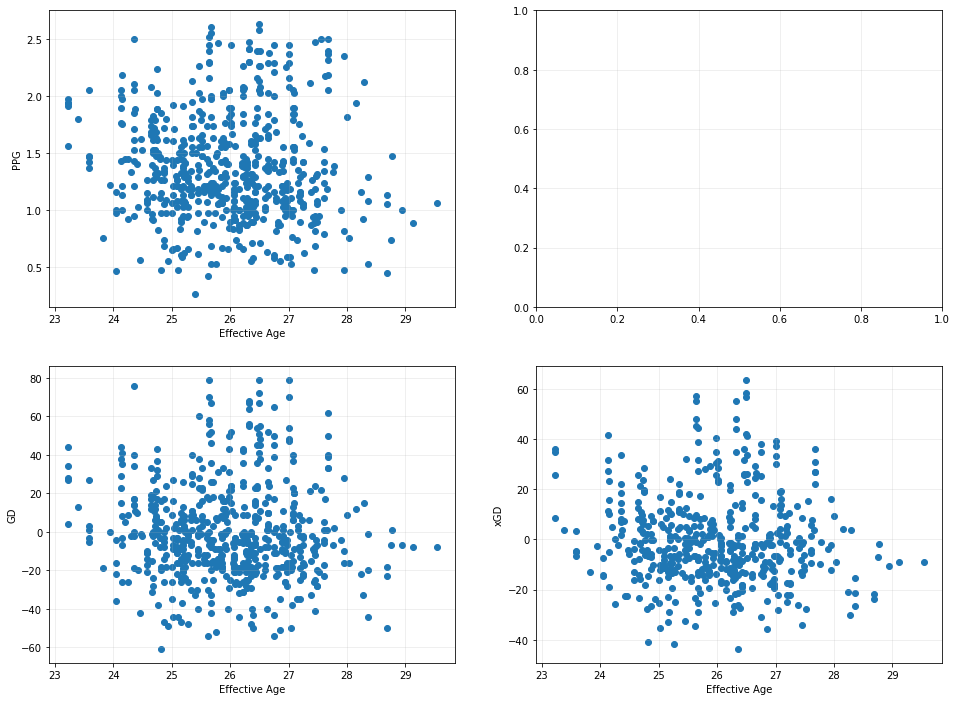

In [136]:
fig, ax = plt.subplots(2,2, figsize=(16,12))
ax[0,0].grid(alpha=0.25)
ax[0,1].grid(alpha=0.25)
ax[1,0].grid(alpha=0.25)
ax[1,1].grid(alpha=0.25)
ax[0,0].scatter(big5_teams['EffAge'], big5_teams['PPG'])
ax[0,0].set_ylabel('PPG')
ax[0,0].set_xlabel('Effective Age')
ax[1,0].scatter(big5_teams['EffAge'], big5_teams['GD'])
ax[1,0].set_ylabel('GD')
ax[1,0].set_xlabel('Effective Age')
ax[1,1].scatter(big5_teams['EffAge'], big5_teams['xGD'])
ax[1,1].set_ylabel('xGD')
ax[1,1].set_xlabel('Effective Age')


In [137]:
big5_teams['PPG_delta'] = np.nan
big5_teams['GD_delta'] = np.nan
big5_teams['xGD_delta'] = np.nan
for i in big5_teams.index:
    team =  big5_teams['Team'][i]
    season = big5_teams['Season'][i]
    lastyear = big5_teams[(big5_teams['Team'] == team) & (big5_teams['Season'] == (season-1))]
    if ((len(lastyear) == 1) and (season < 2021)):
        big5_teams['PPG_delta'][i] = big5_teams['PPG'][i] - lastyear['PPG'].iloc[0]
        big5_teams['GD_delta'][i] = big5_teams['GD'][i] - lastyear['GD'].iloc[0]
        if (~pd.isna(lastyear['xGD'].iloc[0])):
            big5_teams['xGD_delta'][i] = big5_teams['xGD'][i] - lastyear['xGD'].iloc[0]
big5_teams[~pd.isna(big5_teams['xGD_delta'])]

,Team,League,Country,Gender,Tier,Season,URL,Pld,Pts,Max_Pts,GD,xGD,PPG,Team+Nat,EffAge,PPG_delta,GD_delta,xGD_delta
98,Manchester City,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/b8fd03ef/2020-202...,38,86,114,51,42.0,2.263158,Manchester City (ENG),26.487594,0.131579,-16.0,-16.3
99,Manchester Utd,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/19538871/2020-202...,38,74,114,29,18.0,1.947368,Manchester Utd (ENG),25.347514,0.210526,-1.0,-4.0
100,Liverpool,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/822bd0ba/2020-202...,38,69,114,26,27.3,1.815789,Liverpool (ENG),25.668513,-0.789474,-26.0,-4.2
101,Chelsea,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/cff3d9bb/2020-202...,38,67,114,22,31.2,1.763158,Chelsea (ENG),26.018453,0.026316,7.0,2.6
102,Leicester City,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/a2d435b3/2020-202...,38,66,114,18,8.3,1.736842,Leicester City (ENG),25.705095,0.105263,-8.0,-8.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,SPAL,Serie A,ITA,M,1,2018,https://fbref.com//en/squads/1d2fe027/2018-201...,38,42,114,-12,-7.0,1.105263,SPAL (ITA),27.043412,0.105263,8.0,15.2
542,Cagliari,Serie A,ITA,M,1,2018,https://fbref.com//en/squads/c4260e09/2018-201...,38,41,114,-18,-19.4,1.078947,Cagliari (ITA),26.982265,0.052632,10.0,-0.7
543,Fiorentina,Serie A,ITA,M,1,2018,https://fbref.com//en/squads/421387cf/2018-201...,38,41,114,2,10.2,1.078947,Fiorentina (ITA),25.21781,-0.421053,-6.0,-4.5
544,Genoa,Serie A,ITA,M,1,2018,https://fbref.com//en/squads/658bf2de/2018-201...,38,38,114,-18,-10.2,1.0,Genoa (ITA),26.933175,-0.078947,-8.0,-8.0


In [138]:
big5_teams[~pd.isna(big5_teams['PPG_delta'])].sort_values(by='PPG_delta')

,Team,League,Country,Gender,Tier,Season,URL,Pld,Pts,Max_Pts,GD,xGD,PPG,Team+Nat,EffAge,PPG_delta,GD_delta,xGD_delta
344,Monaco,Ligue 1,FRA,M,1,2018,https://fbref.com//en/squads/fd6114db/2018-201...,38,36,114,-19,1.6,0.947368,Monaco (FRA),24.349972,-1.157895,-59.0,-12.9
247,Schalke 04,Fußball-Bundesliga,GER,M,1,2018,https://fbref.com//en/squads/c539e393/2018-201...,34,33,102,-18,-6.7,0.970588,Schalke 04 (GER),24.824516,-0.882353,-34.0,-12.2
117,Sheffield Utd,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/1df6b87e/2020-202...,38,23,114,-43,-31.0,0.605263,Sheffield Utd (ENG),26.7598,-0.815789,-43.0,-24.6
269,Köln,Fußball-Bundesliga,GER,M,1,2017,https://fbref.com//en/squads/bc357bf7/2017-201...,34,22,102,-35,-25.5,0.647059,Köln (GER),25.008242,-0.794118,-44.0,NaN
100,Liverpool,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/822bd0ba/2020-202...,38,69,114,26,27.3,1.815789,Liverpool (ENG),25.668513,-0.789474,-26.0,-4.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,Monaco,Ligue 1,FRA,M,1,2020,https://fbref.com//en/squads/fd6114db/2020-202...,38,78,114,34,33.8,2.052632,Monaco (FRA),24.349972,0.624060,34.0,25.8
239,Wolfsburg,Fußball-Bundesliga,GER,M,1,2018,https://fbref.com//en/squads/4eaa11d7/2018-201...,34,55,102,12,-0.2,1.617647,Wolfsburg (GER),24.901254,0.647059,24.0,10.1
103,West Ham,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/7c21e445/2020-202...,38,65,114,15,5.6,1.710526,West Ham (ENG),26.599532,0.684211,28.0,20.4
451,Valencia,La Liga,ESP,M,1,2017,https://fbref.com//en/squads/dcc91a7b/2017-201...,38,73,114,27,11.2,1.921053,Valencia (ESP),25.020497,0.710526,36.0,NaN


In [139]:
big5_teams[~pd.isna(big5_teams['GD_delta'])].sort_values(by='GD_delta')

,Team,League,Country,Gender,Tier,Season,URL,Pld,Pts,Max_Pts,GD,xGD,PPG,Team+Nat,EffAge,PPG_delta,GD_delta,xGD_delta
344,Monaco,Ligue 1,FRA,M,1,2018,https://fbref.com//en/squads/fd6114db/2018-201...,38,36,114,-19,1.6,0.947368,Monaco (FRA),24.349972,-1.157895,-59.0,-12.9
269,Köln,Fußball-Bundesliga,GER,M,1,2017,https://fbref.com//en/squads/bc357bf7/2017-201...,34,22,102,-35,-25.5,0.647059,Köln (GER),25.008242,-0.794118,-44.0,NaN
507,Parma,Serie A,ITA,M,1,2020,https://fbref.com//en/squads/eab4234c/2020-202...,38,20,114,-44,-21.4,0.526316,Parma (ITA),28.358587,-0.763158,-43.0,-5.9
117,Sheffield Utd,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/1df6b87e/2020-202...,38,23,114,-43,-31.0,0.605263,Sheffield Utd (ENG),26.7598,-0.815789,-43.0,-24.6
215,Schalke 04,Fußball-Bundesliga,GER,M,1,2020,https://fbref.com//en/squads/c539e393/2020-202...,34,16,102,-61,-41.0,0.470588,Schalke 04 (GER),24.824516,-0.676471,-41.0,-26.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,Monaco,Ligue 1,FRA,M,1,2020,https://fbref.com//en/squads/fd6114db/2020-202...,38,78,114,34,33.8,2.052632,Monaco (FRA),24.349972,0.624060,34.0,25.8
108,Aston Villa,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/8602292d/2020-202...,38,55,114,9,0.1,1.447368,Aston Villa (ENG),24.249403,0.526316,35.0,25.9
451,Valencia,La Liga,ESP,M,1,2017,https://fbref.com//en/squads/dcc91a7b/2017-201...,38,73,114,27,11.2,1.921053,Valencia (ESP),25.020497,0.710526,36.0,NaN
158,Manchester City,Premier League,ENG,M,1,2017,https://fbref.com//en/squads/b8fd03ef/2017-201...,38,100,114,79,63.6,2.631579,Manchester City (ENG),26.487594,0.578947,38.0,NaN


In [140]:
big5_teams[~pd.isna(big5_teams['xGD_delta'])].sort_values(by='xGD_delta')

,Team,League,Country,Gender,Tier,Season,URL,Pld,Pts,Max_Pts,GD,xGD,PPG,Team+Nat,EffAge,PPG_delta,GD_delta,xGD_delta
301,Reims,Ligue 1,FRA,M,1,2020,https://fbref.com//en/squads/7fdd64e0/2020-202...,38,42,114,-8,-27.7,1.105263,Reims (FRA),24.807447,-0.359023,-13.0,-29.8
307,Dijon,Ligue 1,FRA,M,1,2020,https://fbref.com//en/squads/8dfb7350/2020-202...,38,21,114,-48,-43.8,0.552632,Dijon (FRA),26.352201,-0.518797,-38.0,-29.6
416,Valencia,La Liga,ESP,M,1,2019,https://fbref.com//en/squads/dcc91a7b/2019-202...,38,53,114,-7,-12.0,1.394737,Valencia (ESP),25.020497,-0.210526,-23.0,-29.0
215,Schalke 04,Fußball-Bundesliga,GER,M,1,2020,https://fbref.com//en/squads/c539e393/2020-202...,34,16,102,-61,-41.0,0.470588,Schalke 04 (GER),24.824516,-0.676471,-41.0,-26.6
341,Bordeaux,Ligue 1,FRA,M,1,2018,https://fbref.com//en/squads/123f3efe/2018-201...,38,41,114,-8,-12.8,1.078947,Bordeaux (FRA),25.153869,-0.368421,-13.0,-24.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,Monaco,Ligue 1,FRA,M,1,2020,https://fbref.com//en/squads/fd6114db/2020-202...,38,78,114,34,33.8,2.052632,Monaco (FRA),24.349972,0.624060,34.0,25.8
108,Aston Villa,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/8602292d/2020-202...,38,55,114,9,0.1,1.447368,Aston Villa (ENG),24.249403,0.526316,35.0,25.9
113,Brighton,Premier League,ENG,M,1,2020,https://fbref.com//en/squads/d07537b9/2020-202...,38,41,114,-6,13.9,1.078947,Brighton (ENG),26.299028,0.000000,9.0,27.2
291,Lyon,Ligue 1,FRA,M,1,2020,https://fbref.com//en/squads/d53c0b06/2020-202...,38,76,114,38,41.4,2.0,Lyon (FRA),24.136791,0.571429,23.0,30.2


In [141]:
big5_teams[big5_teams['Team'] == 'Lille'].sort_values(by='Season')

,Team,League,Country,Gender,Tier,Season,URL,Pld,Pts,Max_Pts,GD,xGD,PPG,Team+Nat,EffAge,PPG_delta,GD_delta,xGD_delta
378,Lille,Ligue 1,FRA,M,1,2016,https://fbref.com//en/squads/cb188c0c/2016-201...,38,46,114,-7,NaN,1.210526,Lille (FRA),24.155925,NaN,NaN,NaN
364,Lille,Ligue 1,FRA,M,1,2017,https://fbref.com//en/squads/cb188c0c/2017-201...,38,38,114,-26,-19.0,1.0,Lille (FRA),24.155925,-0.210526,-19.0,NaN
329,Lille,Ligue 1,FRA,M,1,2018,https://fbref.com//en/squads/cb188c0c/2018-201...,38,75,114,35,15.6,1.973684,Lille (FRA),24.155925,0.973684,61.0,34.6
311,Lille,Ligue 1,FRA,M,1,2019,https://fbref.com//en/squads/cb188c0c/2019-202...,28,49,84,8,10.0,1.75,Lille (FRA),24.155925,-0.223684,-27.0,-5.6
288,Lille,Ligue 1,FRA,M,1,2020,https://fbref.com//en/squads/cb188c0c/2020-202...,38,83,114,41,23.4,2.184211,Lille (FRA),24.155925,0.434211,33.0,13.4
45,Lille,Ligue 1,FRA,M,1,2021,https://fbref.com//en/squads/cb188c0c/Lille-Stats,18,25,54,-1,9.1,1.388889,Lille (FRA),26.210136,NaN,NaN,NaN
